# Packages

In [1]:
import freenect
import cv2
import numpy as np
from numba import njit, prange
import math
import os
import sys
import time
import pickle
from pathlib import Path
import tifffile as tiff
import sys

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib import animation, rc
rc('animation', html='jshtml')

from IPython.display import HTML
from collections import deque
from tqdm.notebook import tqdm
from behavior_functions import *
from hmmlearn import hmm

from scipy.ndimage import median_filter
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d, median_filter

### Additional infos

- If a gif is needed, screenshots of a code snipped dating back to 13-12-23 can be found and used

# Dataset_list creation

In [172]:
# Behavior folder in which all sessions are.

behavior_path = "/Users/vincentchouinard/Documents/Maitrise/Behavior"

# session_keywords and mouse_keywords are lists of form ['S1', 'S2', 'S5'] or ['M29', 'M33', 'M37'], respectively.
# It can also be "all" if all sessions and mice are selected for analysis.
session_keywords = ["S1", "S2", "S3", "S4", "S5", "S6"]
mouse_keywords = "all"

In [173]:
dataset_list = dataset_paths(behavior_path, session_keywords, mouse_keywords, verbose = True)
print("Number of datasets: " ,len(dataset_list))

Mouse keywords:  ['M28', 'M29', 'M31', 'M33', 'M34', 'M35', 'M37', 'M38', 'M39', 'M40', 'M41', 'M42', 'M44']
Session keywords:  ['S1', 'S2', 'S3', 'S4', 'S5', 'S6']
Number of datasets:  62


In [174]:
dataset_list

['/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M34_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M35_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M37_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M38_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M

In [ ]:
coords = []
for i in range(len(dataset_list)):
    coords.append(select_center(dataset_list[i] + "/video.avi", verbose=False))
    
for i in tqdm(range(len(dataset_list)), desc="Batch cropping"):
    crop_video_and_depth(dataset_list[i], coords[i])

In [23]:
for dataset_path in tqdm(dataset_list):
    find_background_mode(dataset_path, verbose = False)
    substract_background_with_array(dataset_path)

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/18878 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/bg_sub_cropped_video.avi


  0%|          | 0/18879 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
for i in tqdm(range(len(dataset_list))):
    binarize_video(dataset_list[i])

In [10]:
coords2 = compute_centroids(dataset_list[0])

  0%|          | 0/2303 [00:00<?, ?it/s]

In [ ]:
for i in range(len(dataset_list)):
    save_mask_depth(dataset_list[i])

In [12]:
z = obtain_depth(dataset_list[0])

Error: Could not open depth video file.


OpenCV: Couldn't read video stream from file "/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/depth_mask.avi"
[ERROR:0@1278.253] global cap.cpp:166 open VIDEOIO(CV_IMAGES): raised OpenCV exception:

OpenCV(4.8.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/videoio/src/cap_images.cpp:253: error: (-5:Bad argument) CAP_IMAGES: can't find starting number (in the name of file): /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S5/BH_M28_S5/depth_mask.avi in function 'icvExtractPattern'




In [10]:
import numpy as np
from scipy.ndimage import gaussian_filter1d

def apply_gaussian_filter1d(arr, sigma):
    return gaussian_filter1d(arr, sigma)

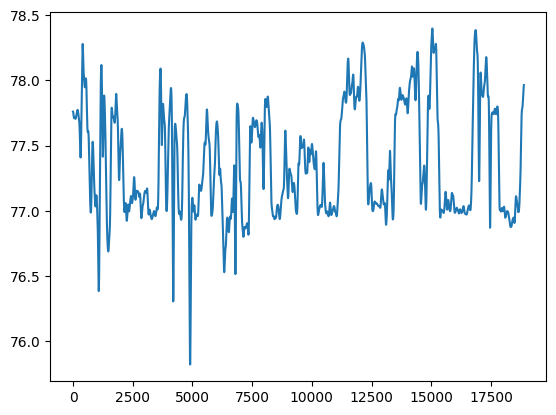

In [11]:
filt = apply_gaussian_filter1d(z, 20)
plt.plot(filt)
plt.show()

In [77]:
x,y,z = apply_gaussian_filter1d(coords2[:,0], 20), apply_gaussian_filter1d(coords2[:,1], 20), apply_gaussian_filter1d(z, 20)

In [97]:
a = count_pixels(dataset_list[0])

  0%|          | 0/18879 [00:00<?, ?it/s]

# tests

In [64]:
regression = predicted_y-np.min(predicted_y)

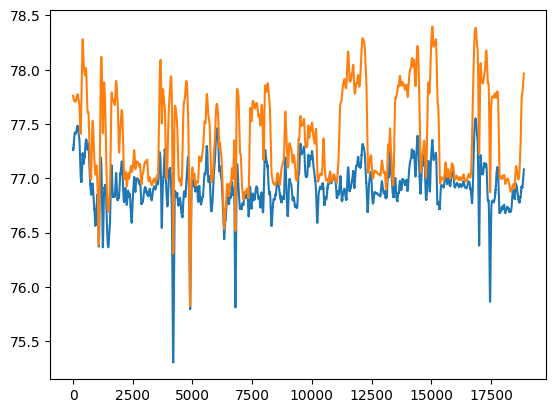

In [65]:
plt.plot(z-regression)
plt.plot(filt)

In [94]:
new_z = detrend_linear2d(x,y,z)

# Dataset processing

In [13]:
roi = []
for i in range(len(dataset_list)):

    # Premake rectangles to crop
    roi.append(select_center(dataset_list[i] + "/video.avi", verbose=False))
    
for i in tqdm(range(len(dataset_list)), desc="Batch cropping"):
    
    # crop (with premade rectangles in coords)
    crop_video_and_depth(dataset_list[i], roi[i])
    
    # Substract background
    find_background_mode(dataset_list[i], verbose = False)
    substract_background_with_array(dataset_list[i])
    
    # Binarize
    binarize_video(dataset_list[i])
    
    # Saving video mask to use with depth and coords
    save_mask_depth(dataset_list[i])
    
    # Computing centroids
    xy_coords = compute_centroids(dataset_list[i])
    
    # Obtaining depth for z
    z_coord = obtain_depth(dataset_list[i])
    
    # Filter and combine x,y and z
    x,y,z = gaussian_filter1d(xy_coords[:,0], 20), gaussian_filter1d(xy_coords[:,1], 20), gaussian_filter1d(z_coord, 20)
    z = detrend_linear2d(x,y,z)
    coords = np.column_stack((x, y, z))
    
    print("Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.")
    
    del xy_coords, z_coord, x, y, z
    
    # saving coordinate dictionary with pickle
    coords_dict = {}
    coords_dict['coords'] = coords
    
    folderpath = Path(dataset_list[i])
    metadatapath = folderpath.joinpath("metadata.pkl")
    
    save_dict(str(metadatapath), coords_dict)
    print('Processing of {} is completed.'.format(str(Path(dataset_list[i]).name)))

Batch cropping:   0%|          | 0/48 [00:00<?, ?it/s]

Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M28_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M28_S1 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M29_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M29_S1 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M31_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M31_S1 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M33_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M33_S1 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M34_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M34_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M34_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M34_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M34_S1 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M35_S1/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M35_S1/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M35_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M35_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M35_S1 is completed.


Processing video:   0%|          | 0/17982 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M37_S1/cropped_video.avi


Processing depth:   0%|          | 0/17982 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M37_S1/cropped_depth.avi


  0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M37_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17982 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M37_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17981 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M37_S1 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M38_S1/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M38_S1/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M38_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M38_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M38_S1 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M39_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M39_S1 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M40_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M40_S1 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M41_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M41_S1 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M42_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M42_S1 is completed.


Processing video:   0%|          | 0/18880 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1/cropped_video.avi


Processing depth:   0%|          | 0/18880 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1/cropped_depth.avi


  0%|          | 0/18879 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/18880 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S1/BH_M44_S1/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/18879 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M44_S1 is completed.


Processing video:   0%|          | 0/17982 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2/cropped_video.avi


Processing depth:   0%|          | 0/17982 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2/cropped_depth.avi


  0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17982 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M28_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17981 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M28_S2 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M29_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M29_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M31_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M31_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M33_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M33_S2 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M34_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M34_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M35_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M35_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M35_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M35_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M35_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M37_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M37_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M37_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M37_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M37_S2 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M38_S2/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M38_S2/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M38_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M38_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M38_S2 is completed.


Processing video:   0%|          | 0/16774 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M39_S2/cropped_video.avi


Processing depth:   0%|          | 0/16774 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M39_S2/cropped_depth.avi


  0%|          | 0/16773 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M39_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/16774 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M39_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/16773 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M39_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M40_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M40_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M40_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M40_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M40_S2 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M41_S2/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M41_S2/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M41_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M41_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M41_S2 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M42_S2/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M42_S2/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M42_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M42_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M42_S2 is completed.


Processing video:   0%|          | 0/18879 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M44_S2/cropped_video.avi


Processing depth:   0%|          | 0/18879 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M44_S2/cropped_depth.avi


  0%|          | 0/18878 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M44_S2/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/18879 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S2/BH_M44_S2/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/18878 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M44_S2 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M28_S3/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M28_S3/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M28_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M28_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M28_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M29_S3/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M29_S3/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M29_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M29_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M29_S3 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M31_S3/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M31_S3/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M31_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M31_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M31_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M33_S3/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M33_S3/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M33_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M33_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M33_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M34_S3/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M34_S3/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M34_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M34_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M34_S3 is completed.


Processing video:   0%|          | 0/17965 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M35_S3/cropped_video.avi


Processing depth:   0%|          | 0/17965 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M35_S3/cropped_depth.avi


  0%|          | 0/17964 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M35_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17965 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M35_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17964 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M35_S3 is completed.


Processing video:   0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M37_S3/cropped_video.avi


Processing depth:   0%|          | 0/17979 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M37_S3/cropped_depth.avi


  0%|          | 0/17978 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M37_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17979 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M37_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17978 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M37_S3 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M38_S3/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M38_S3/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M38_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M38_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M38_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M39_S3/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M39_S3/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M39_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M39_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M39_S3 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M40_S3/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M40_S3/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M40_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M40_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M40_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M41_S3/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M41_S3/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M41_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M41_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M41_S3 is completed.


Processing video:   0%|          | 0/17982 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M42_S3/cropped_video.avi


Processing depth:   0%|          | 0/17982 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M42_S3/cropped_depth.avi


  0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M42_S3/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17982 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S3/BH_M42_S3/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17981 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M42_S3 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M28_S4/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M28_S4/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M28_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M28_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M28_S4 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M29_S4/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M29_S4/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M29_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M29_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M29_S4 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M31_S4/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M31_S4/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M31_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M31_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M31_S4 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M33_S4/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M33_S4/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M33_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M33_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M33_S4 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M34_S4/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M34_S4/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M34_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M34_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M34_S4 is completed.


Processing video:   0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M35_S4/cropped_video.avi


Processing depth:   0%|          | 0/17979 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M35_S4/cropped_depth.avi


  0%|          | 0/17978 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M35_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17979 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M35_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17978 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M35_S4 is completed.


Processing video:   0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M37_S4/cropped_video.avi


Processing depth:   0%|          | 0/17979 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M37_S4/cropped_depth.avi


  0%|          | 0/17978 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M37_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17979 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M37_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17978 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M37_S4 is completed.


Processing video:   0%|          | 0/17981 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M38_S4/cropped_video.avi


Processing depth:   0%|          | 0/17981 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M38_S4/cropped_depth.avi


  0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M38_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17981 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M38_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17980 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M38_S4 is completed.


Processing video:   0%|          | 0/17980 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M39_S4/cropped_video.avi


Processing depth:   0%|          | 0/17980 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M39_S4/cropped_depth.avi


  0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M39_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17980 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M39_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17979 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M39_S4 is completed.


Processing video:   0%|          | 0/17979 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M42_S4/cropped_video.avi


Processing depth:   0%|          | 0/17979 [00:00<?, ?it/s]

Output depth saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M42_S4/cropped_depth.avi


  0%|          | 0/17978 [00:00<?, ?it/s]

Output video saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M42_S4/bg_sub_cropped_video.avi


Binarizing mask_video.tif:   0%|          | 0/17979 [00:00<?, ?it/s]

Output saved to /Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S4/BH_M42_S4/mask_video.tif
Depth data saved as 'depth_mask.avi'.


  0%|          | 0/17978 [00:00<?, ?it/s]

Filtered and detrended x,y and z coordinates are combined in a metadata dictionary.
Processing of BH_M42_S4 is completed.


In [9]:
def show_coords(coord_dict):
    # Creating a 3x1 subplot layout with more horizontal orientation
    plt.figure(figsize=(12, 6))

    # Plotting x(t)
    plt.subplot(3, 1, 1)
    plt.plot(coord_dict['coords'][:,0], color='red')
    plt.title('x(t)')

    # Plotting y(t)
    plt.subplot(3, 1, 2)
    plt.plot(coord_dict['coords'][:,1], color='green')
    plt.title('y(t)')

    # Plotting z(t)
    plt.subplot(3, 1, 3)
    plt.plot(coord_dict['coords'][:,2], color='blue')
    plt.title('z(t)')

    # Adjust layout to prevent overlapping
    plt.tight_layout()

    # Show the plot
    plt.show()

In [16]:
def total_movement(coordinates):
    # Select x,y only
    coordinates = np.copy(coordinates[:,:2])
    
    # Calculate the differences between consecutive coordinates
    differences = np.diff(coordinates.astype(np.float32()), axis=0)
    
    # Calculate the Euclidean distance for each pair of points
    distances = np.sqrt(np.sum(differences**2, axis=1))
    
    # Sum up the distances to get the total movement
    total_distance = np.sum(distances)
    
    return total_distance

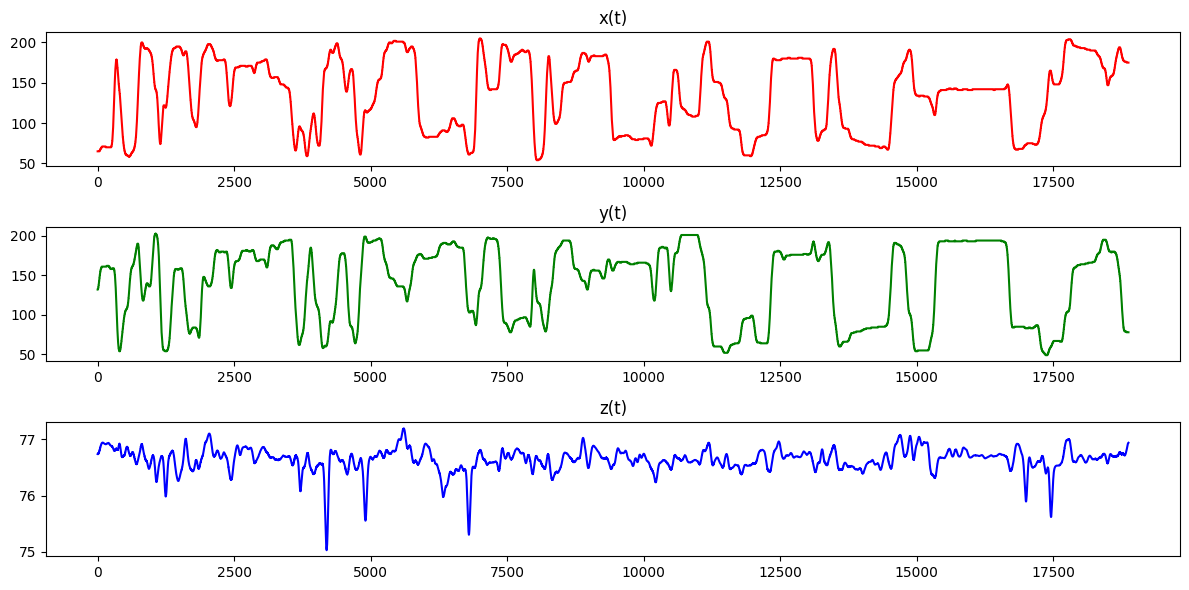

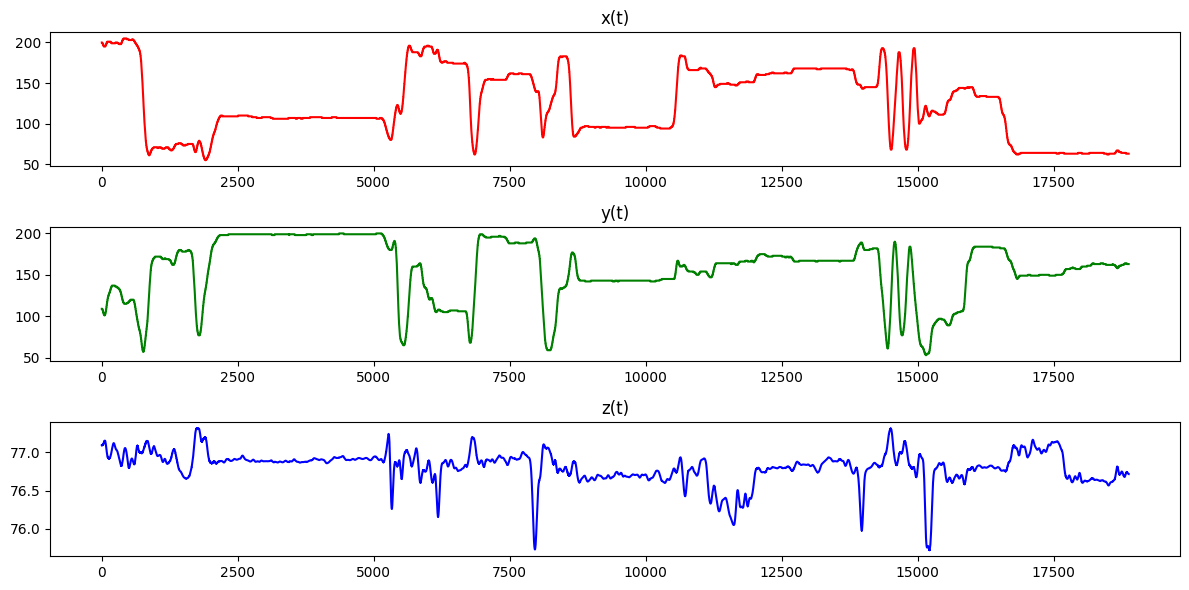

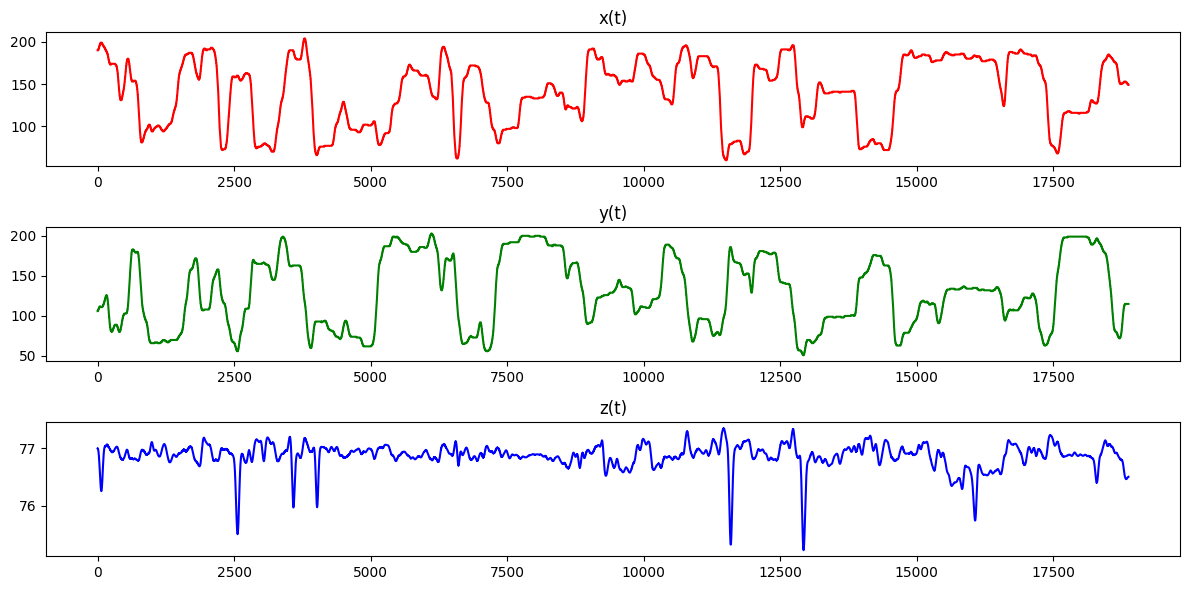

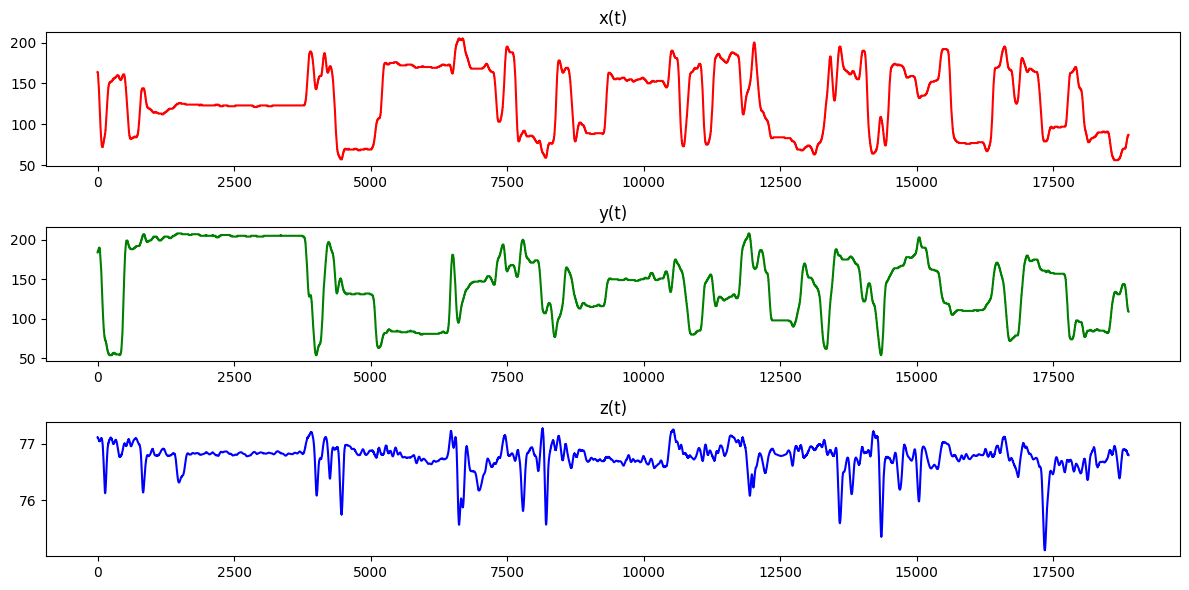

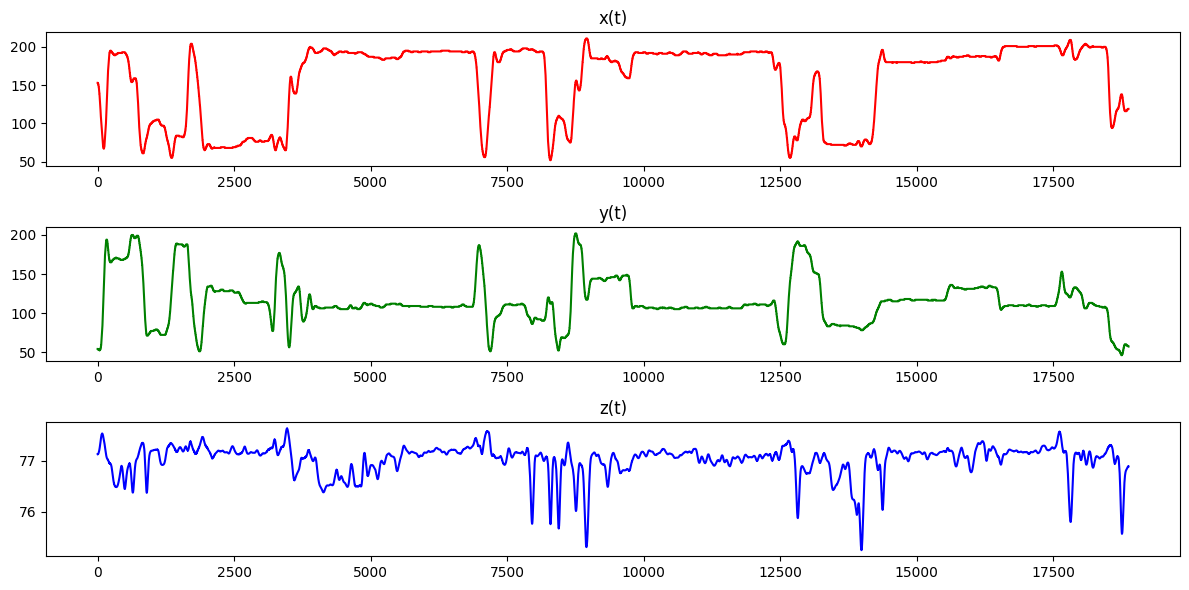

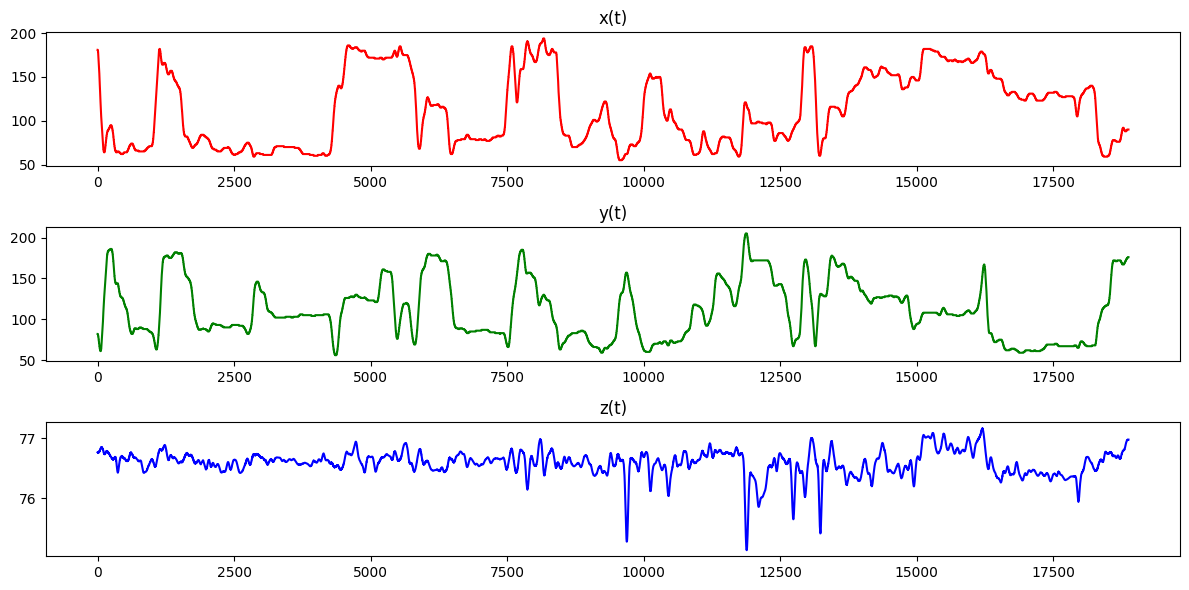

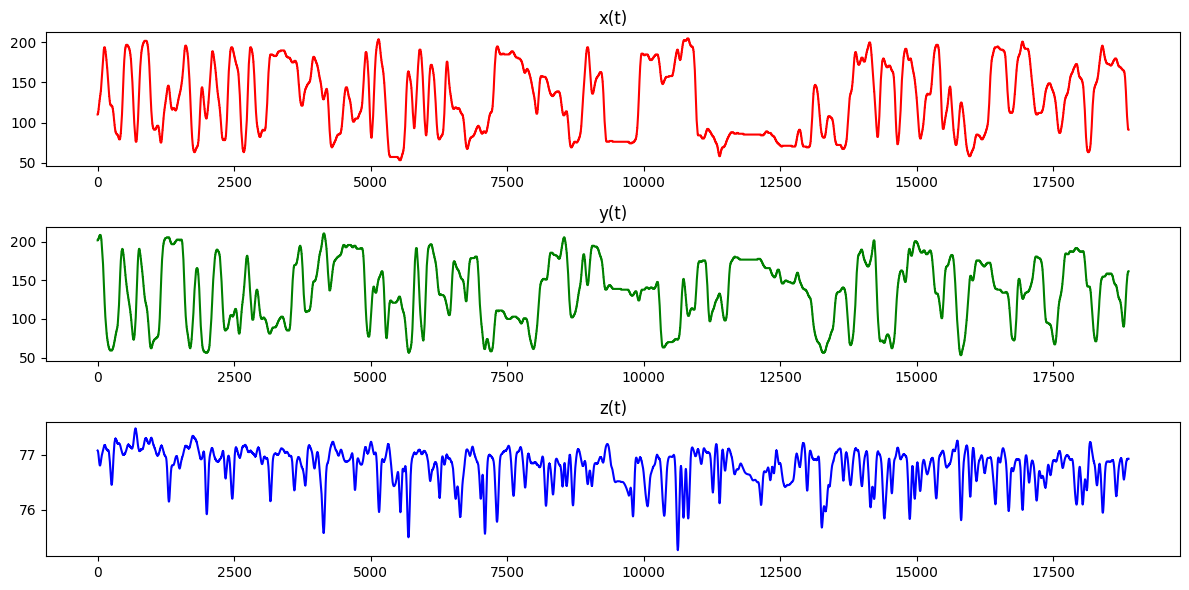

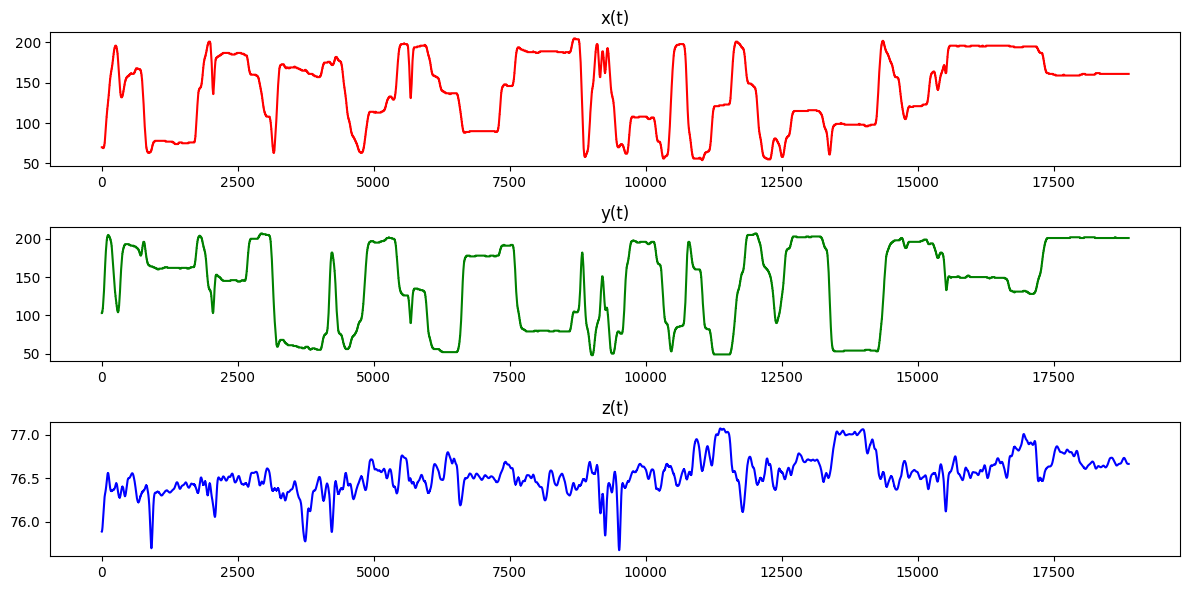

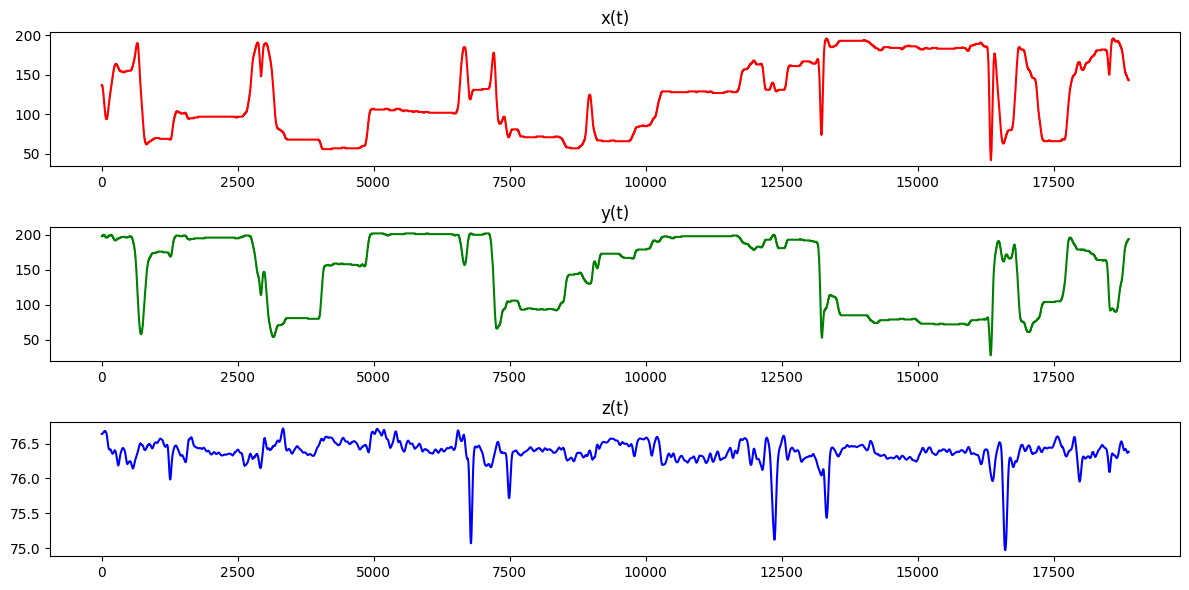

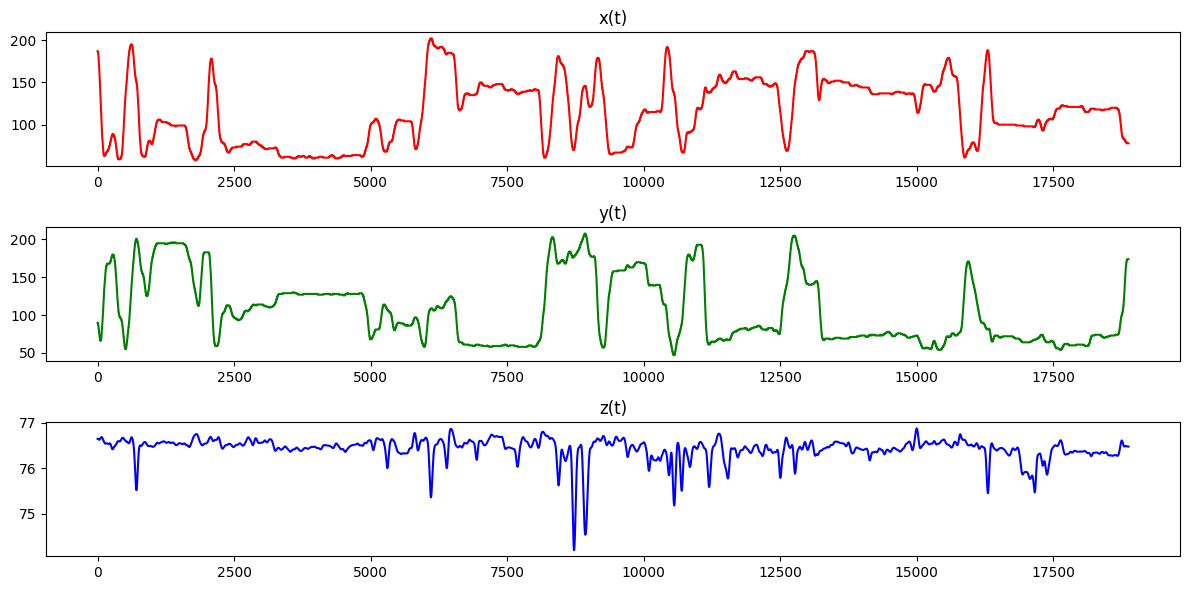

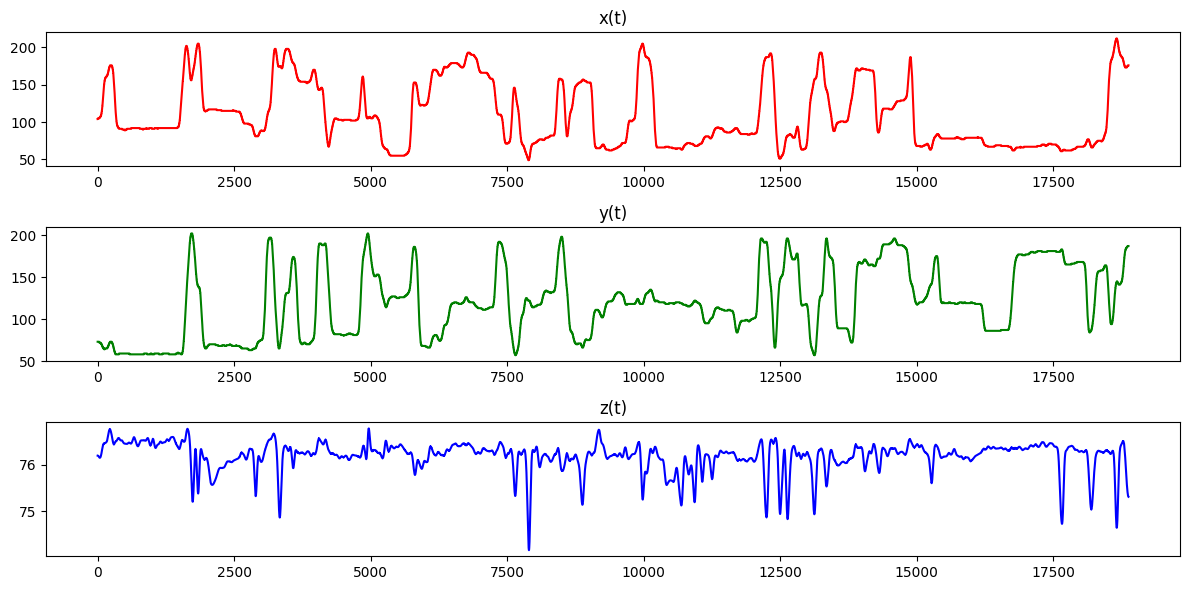

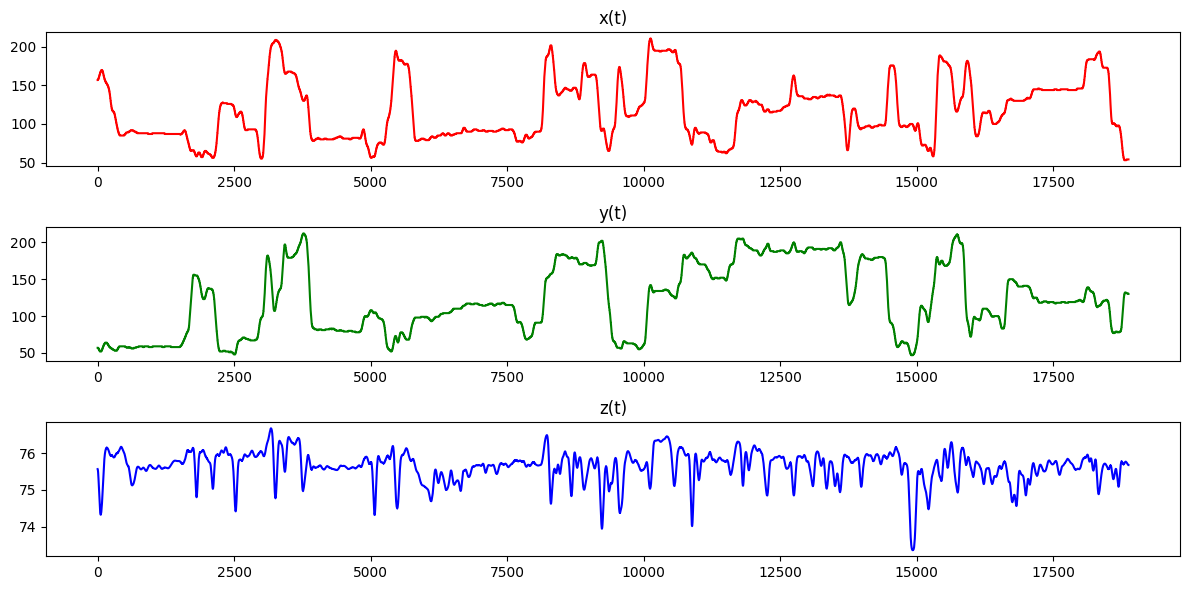

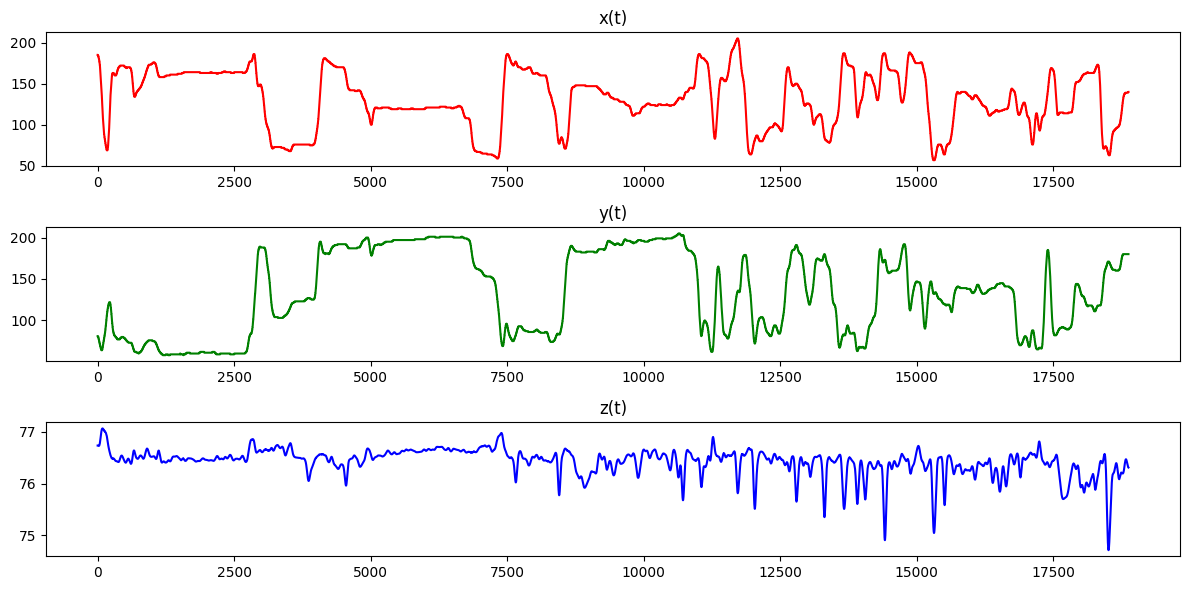

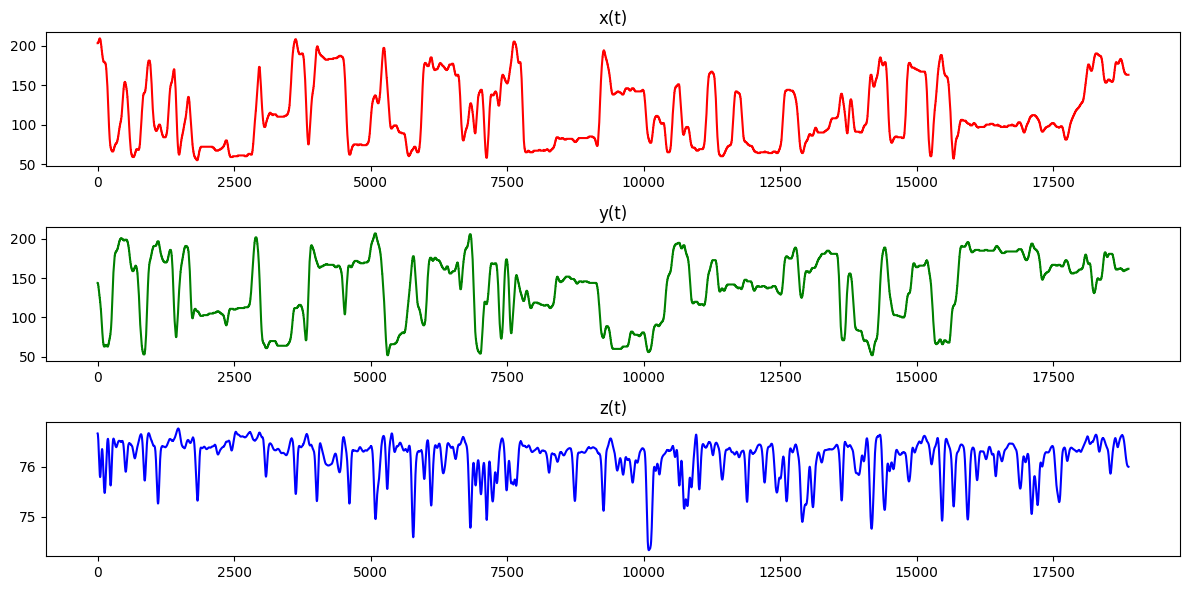

In [10]:
for i in range(len(dataset_list)):
    coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    show_coords(coord_dict)

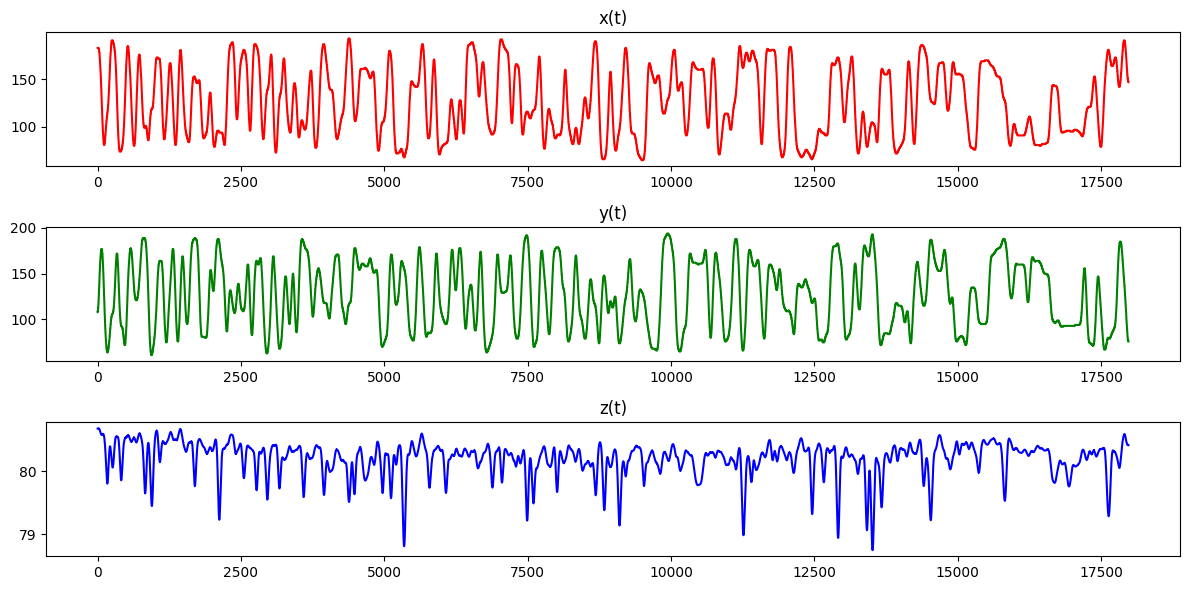

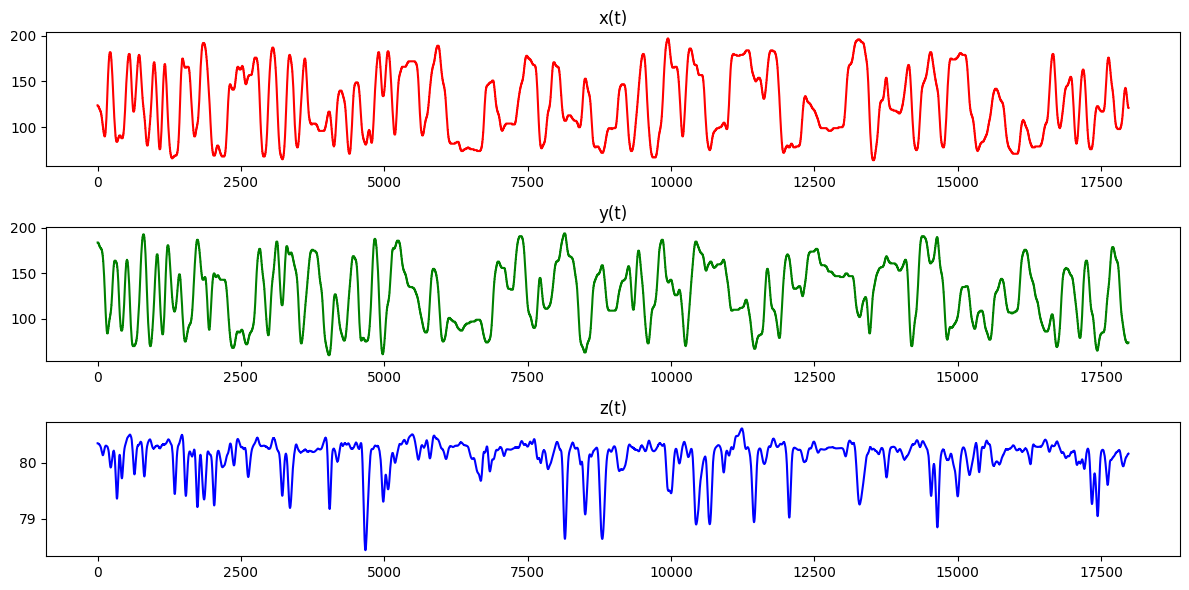

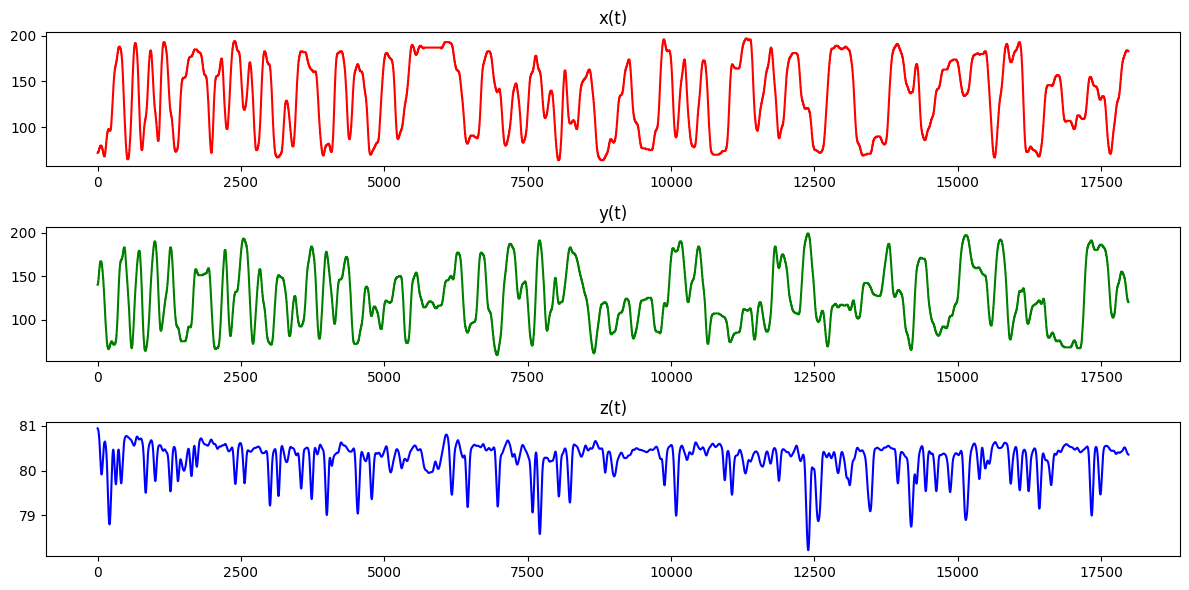

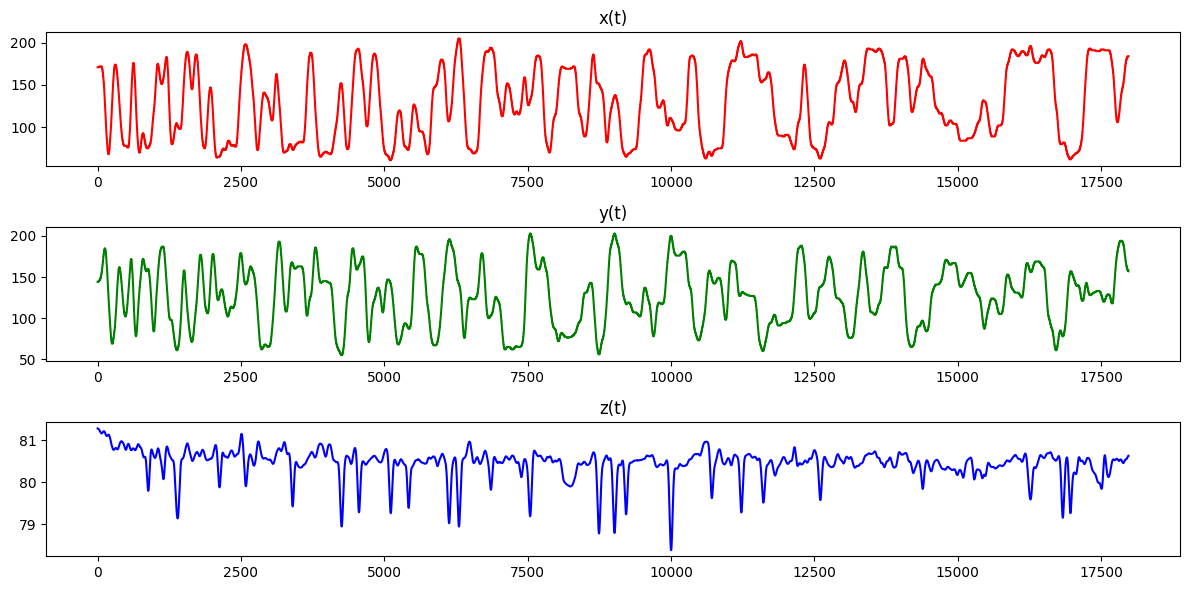

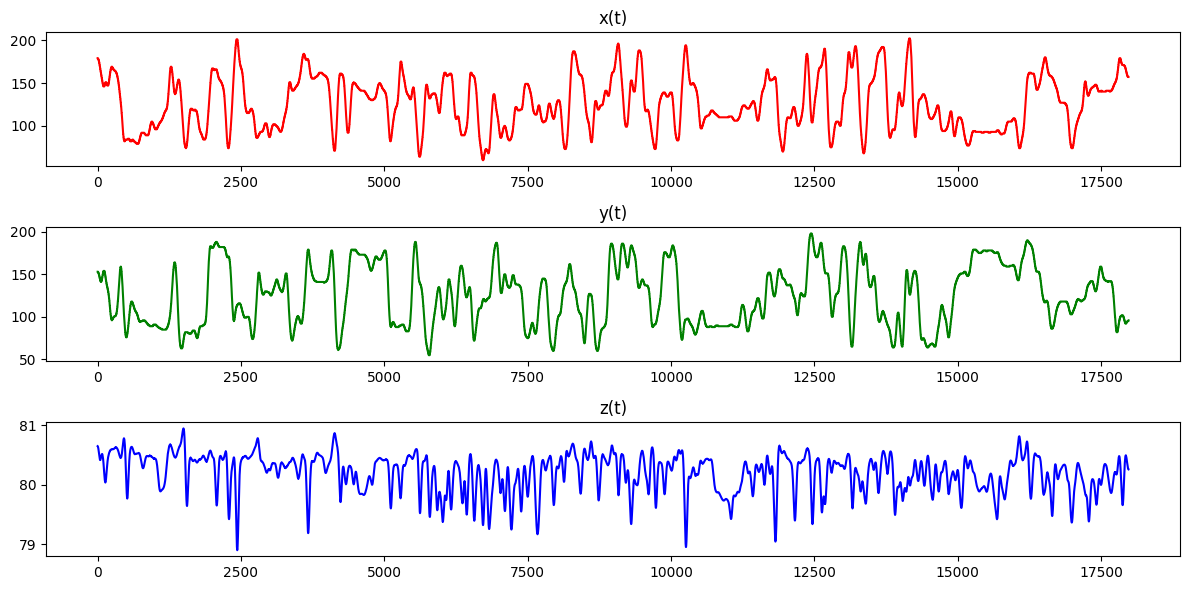

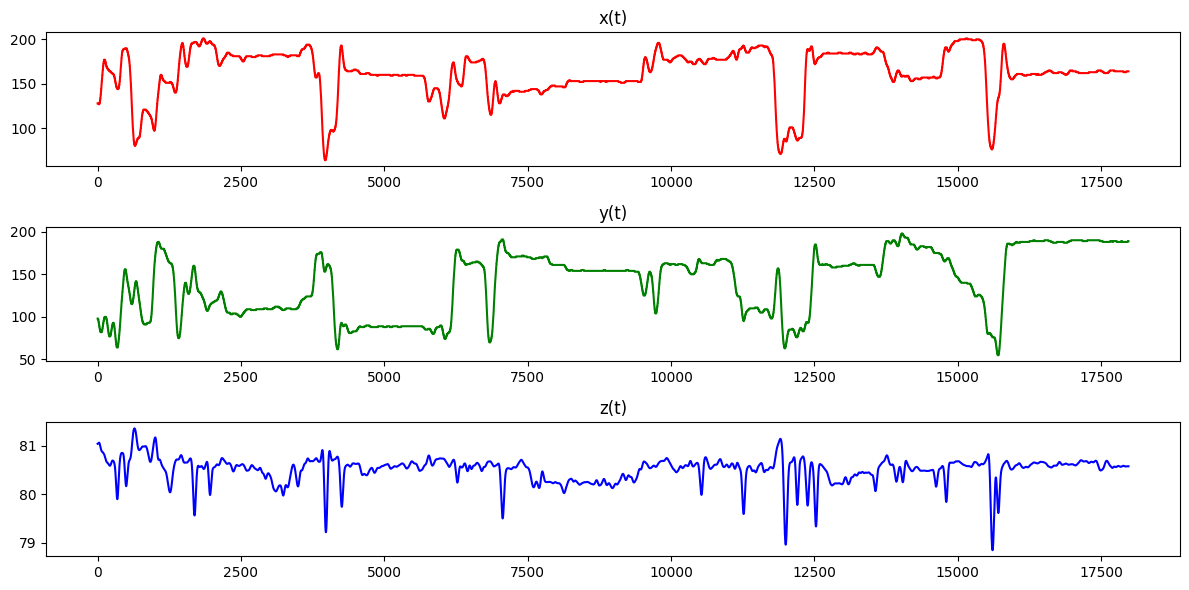

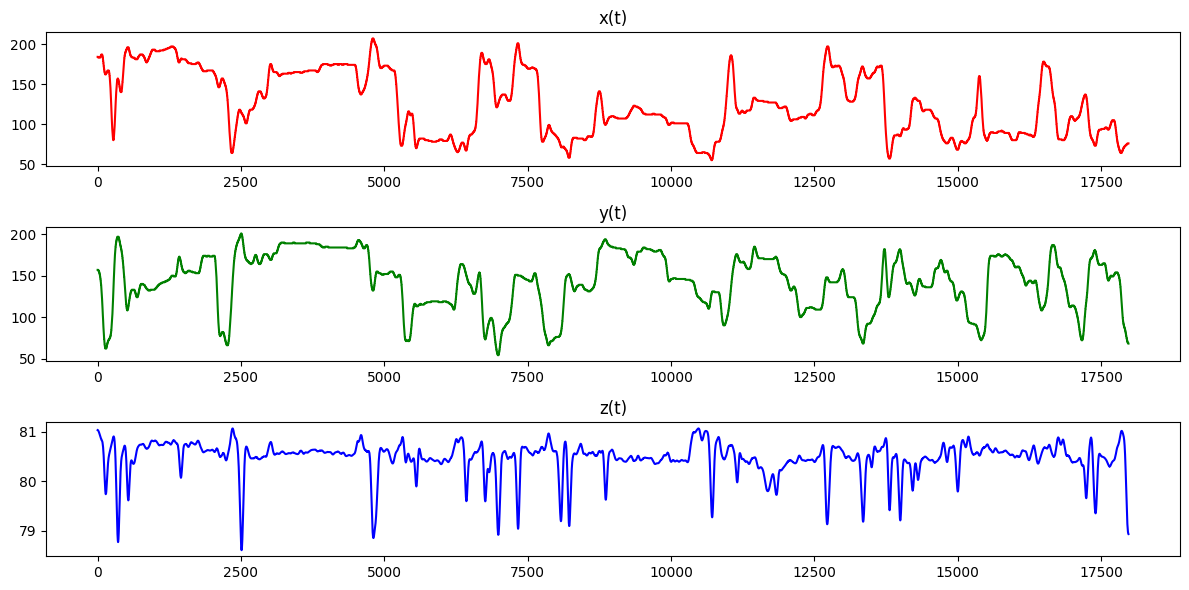

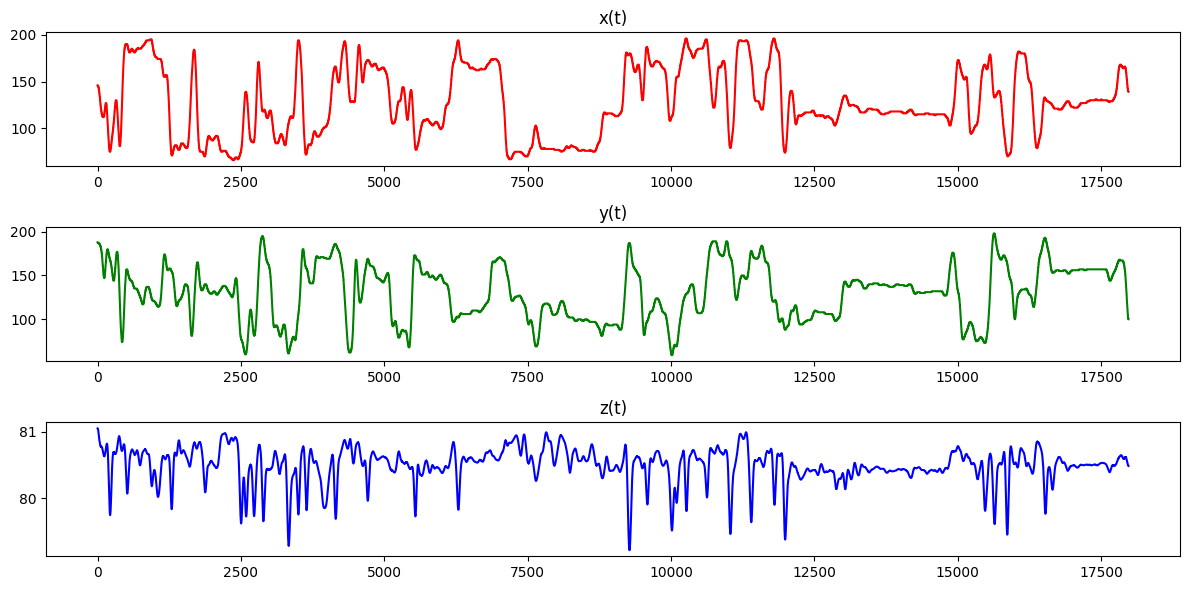

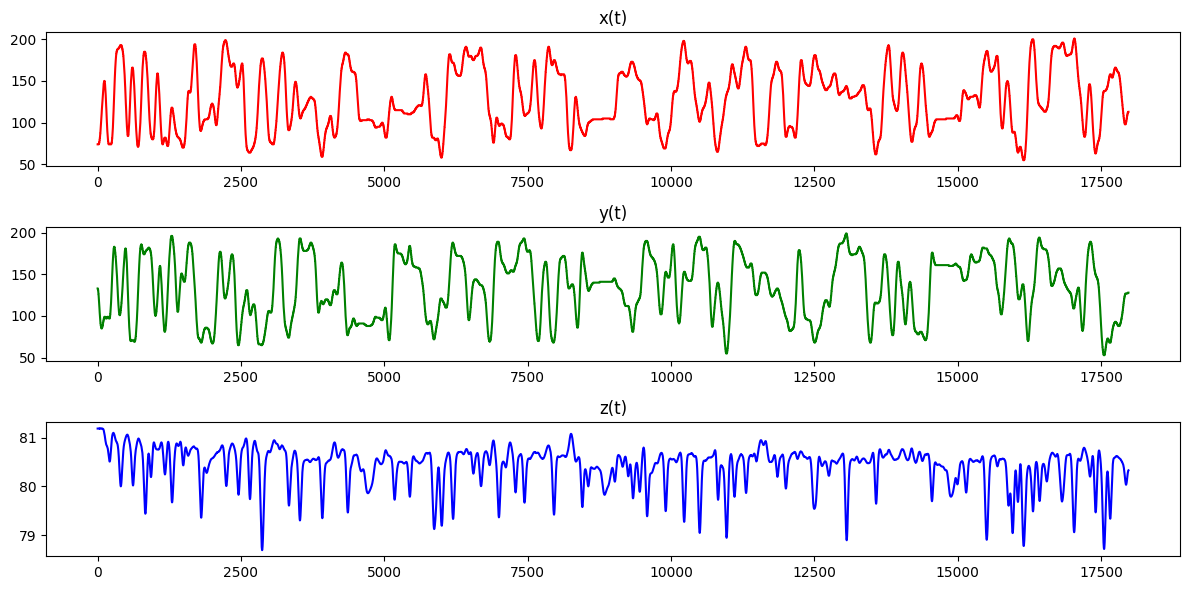

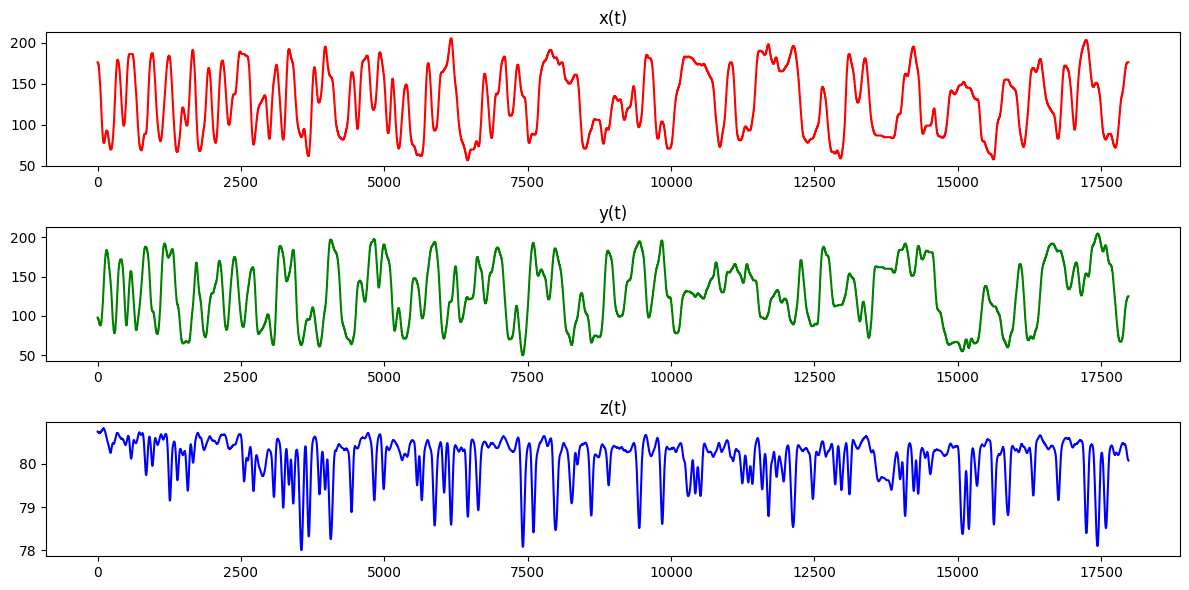

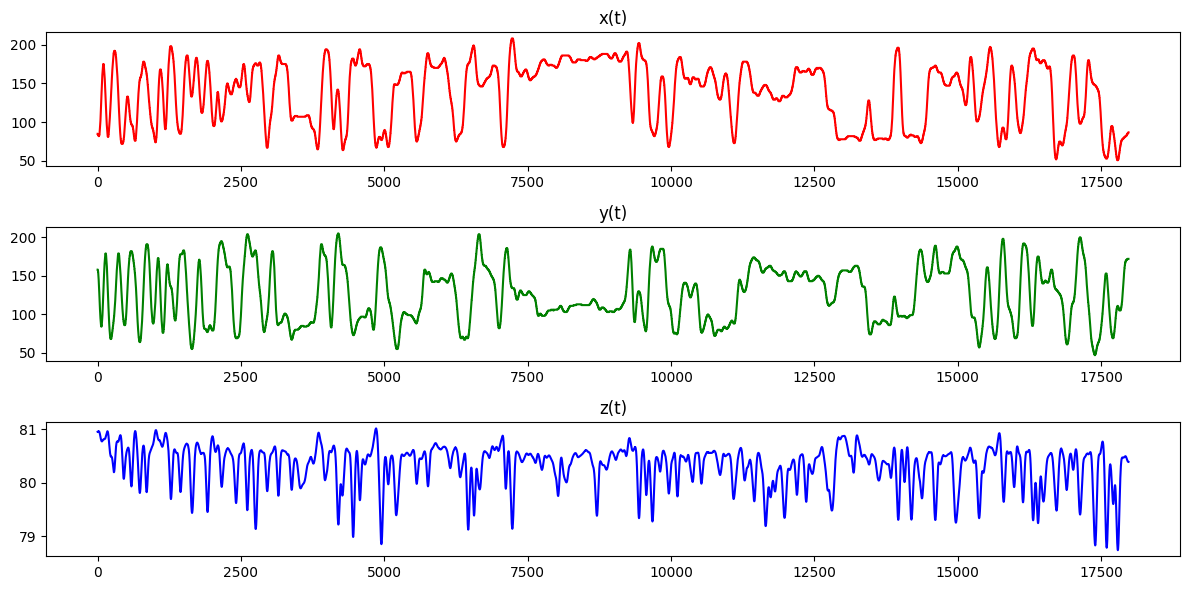

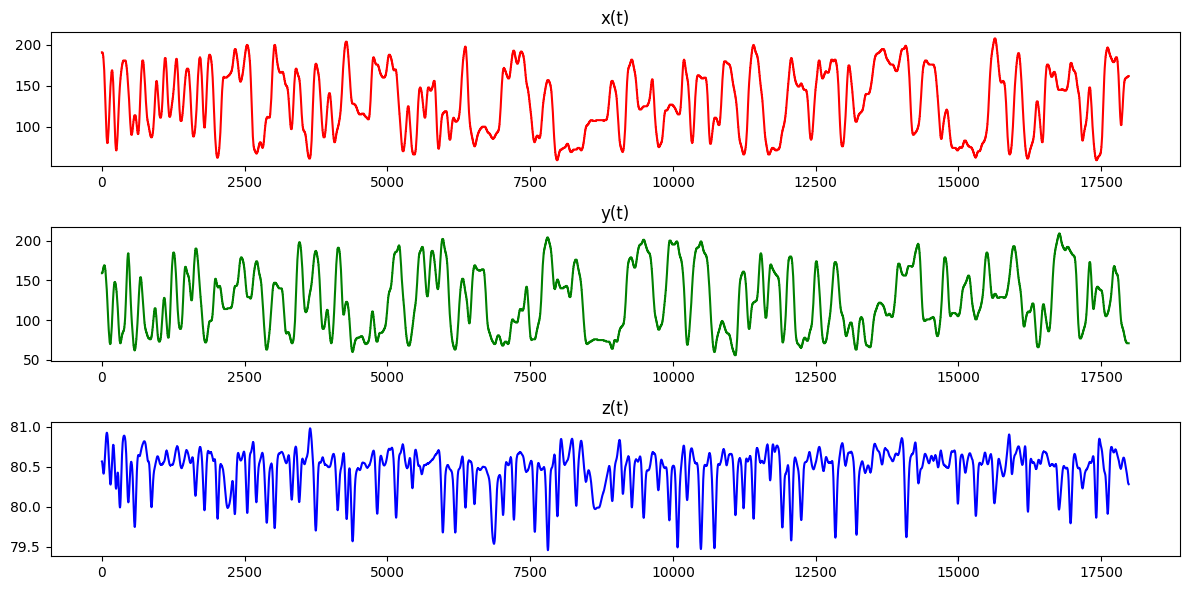

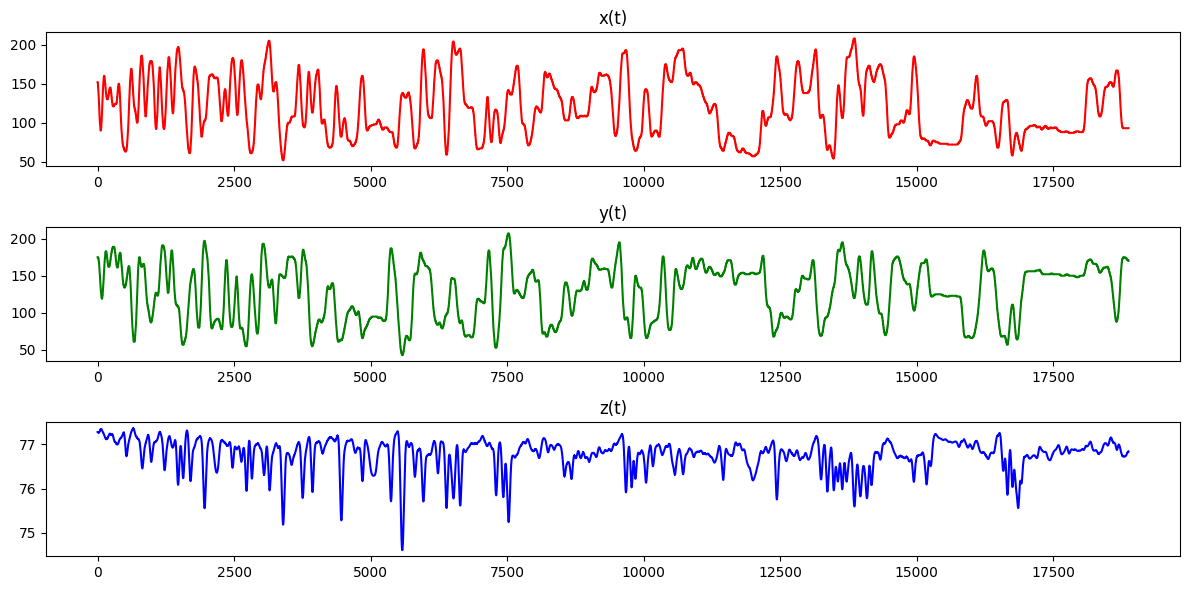

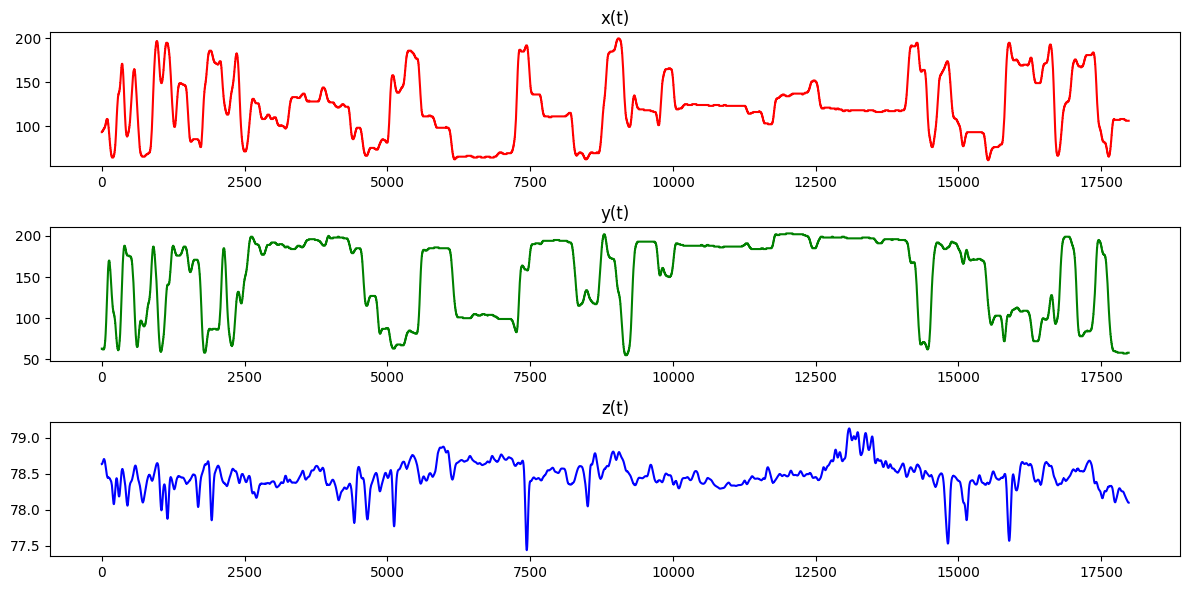

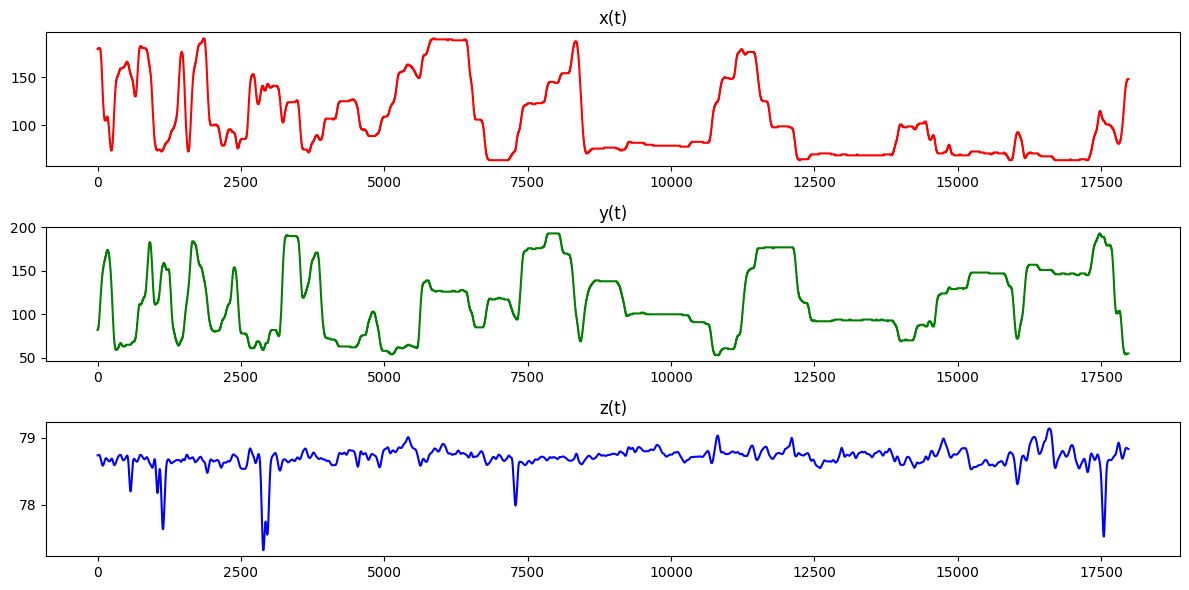

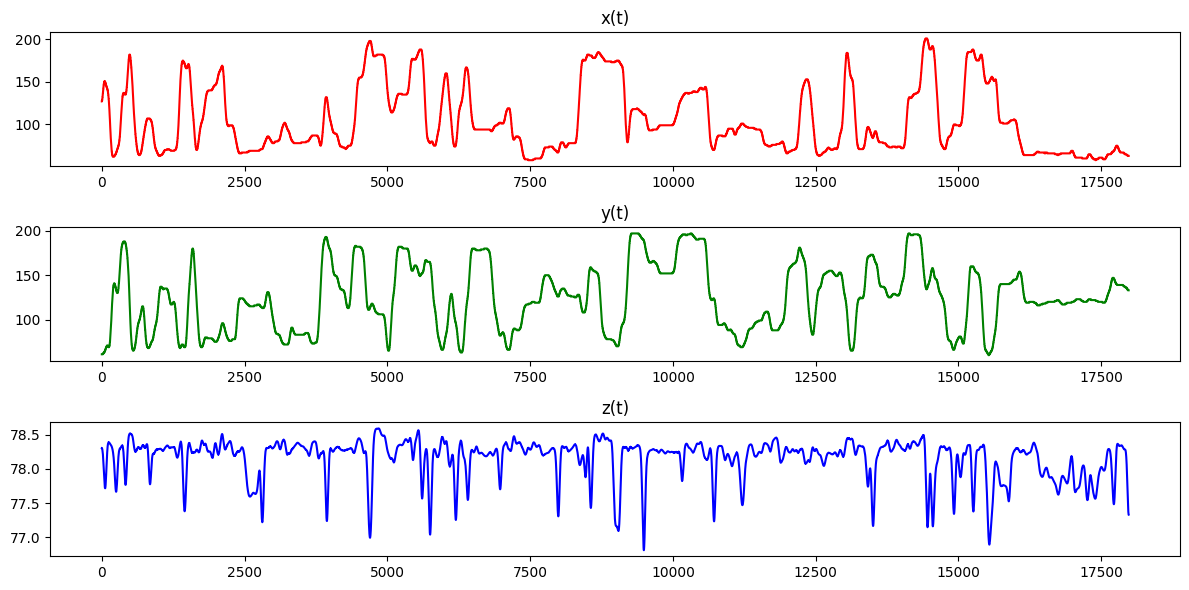

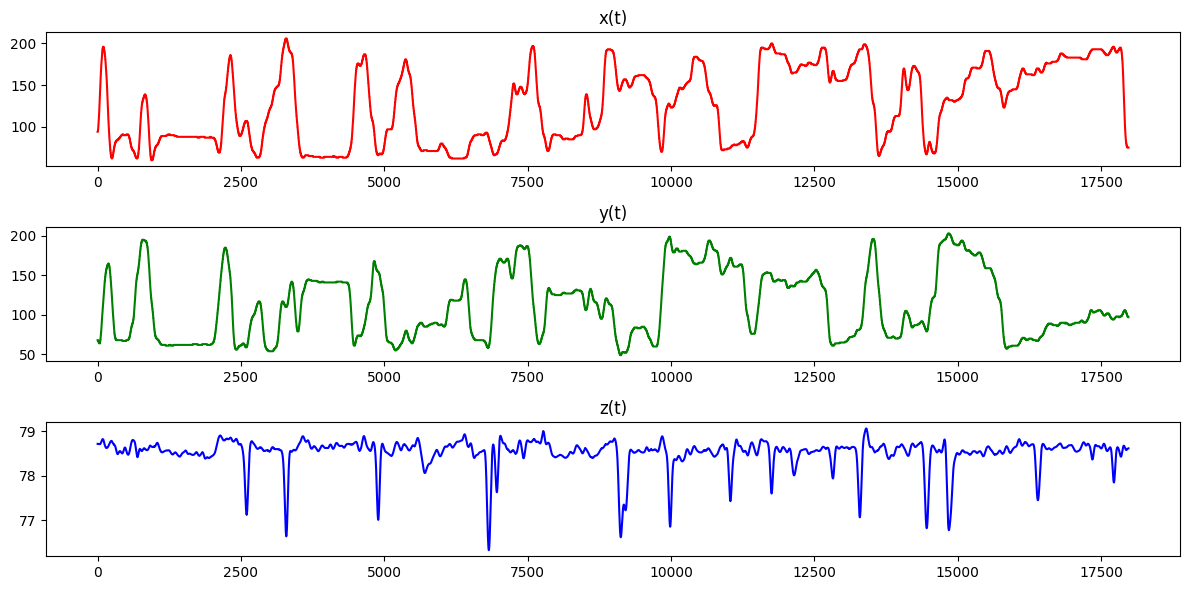

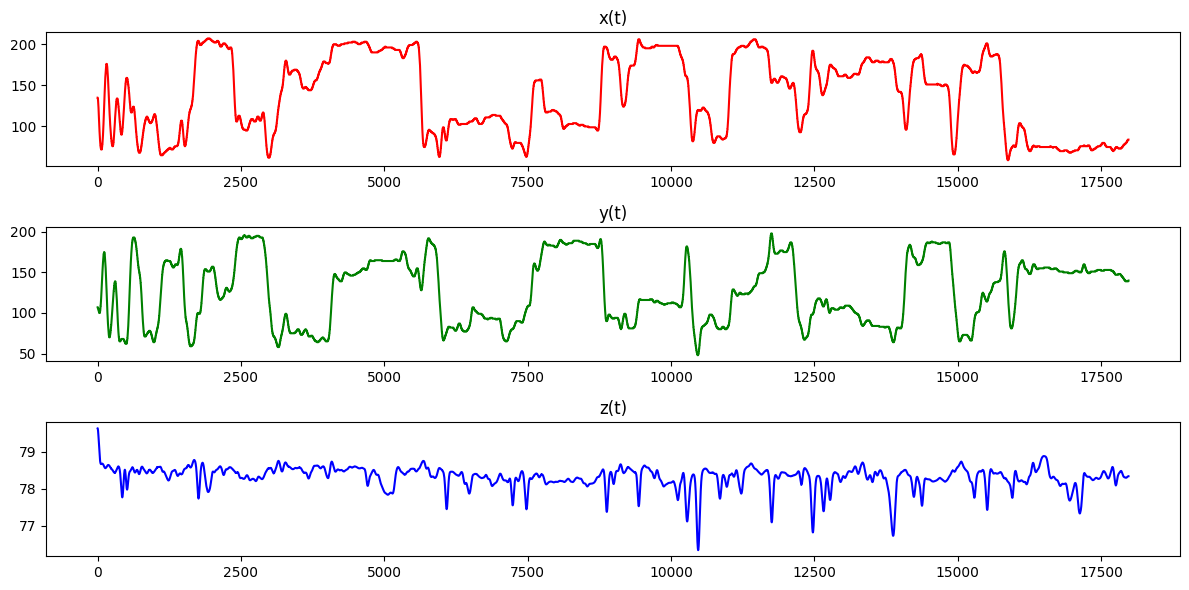

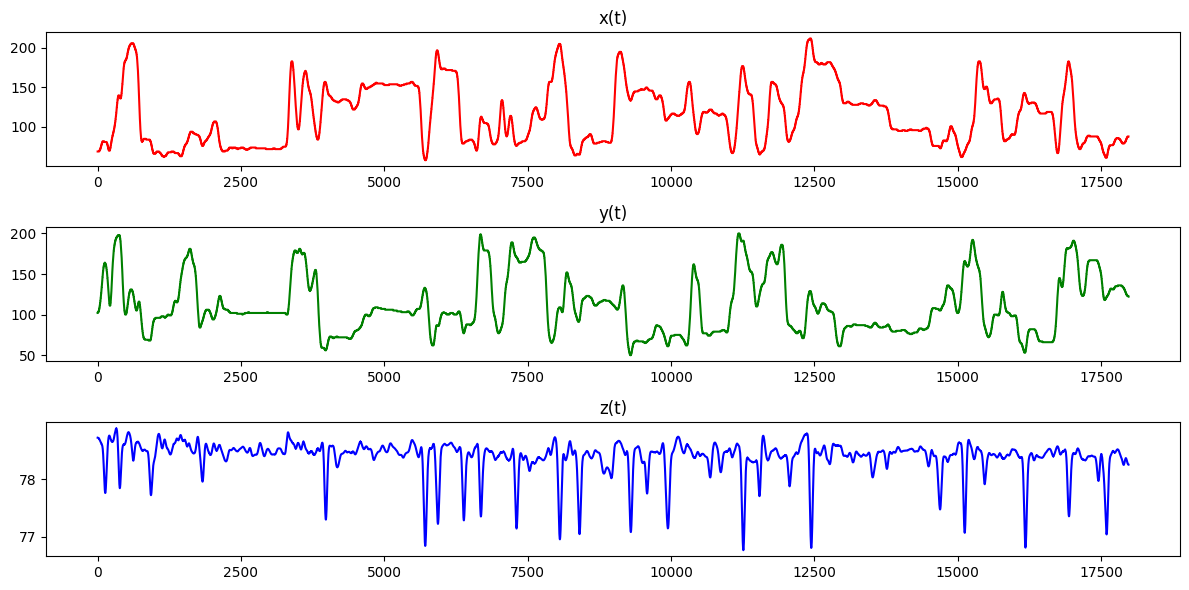

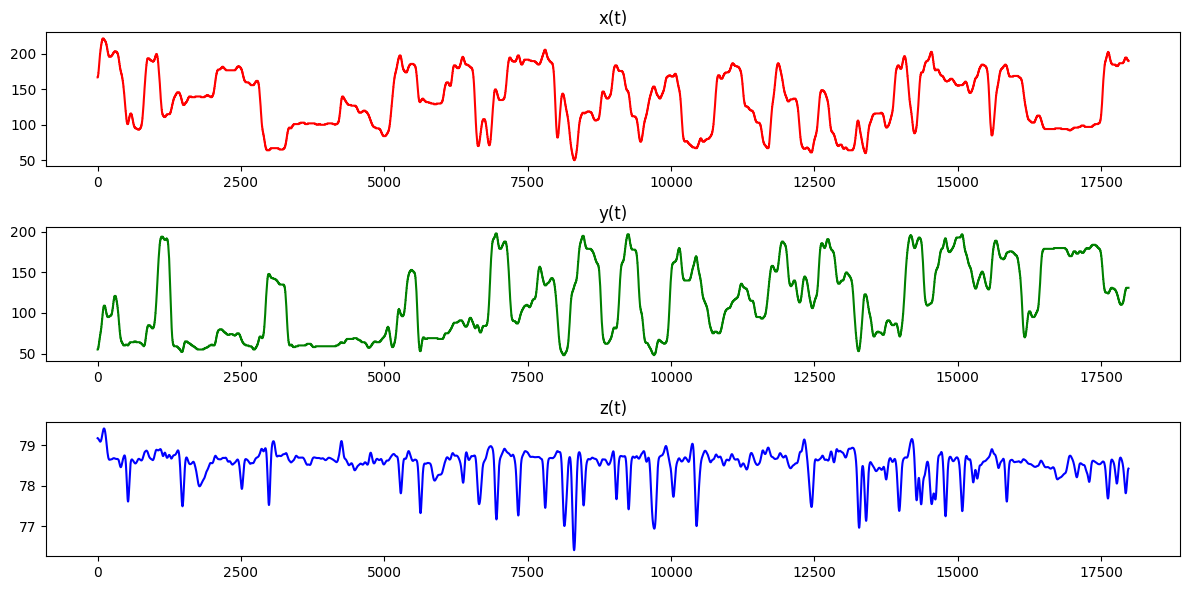

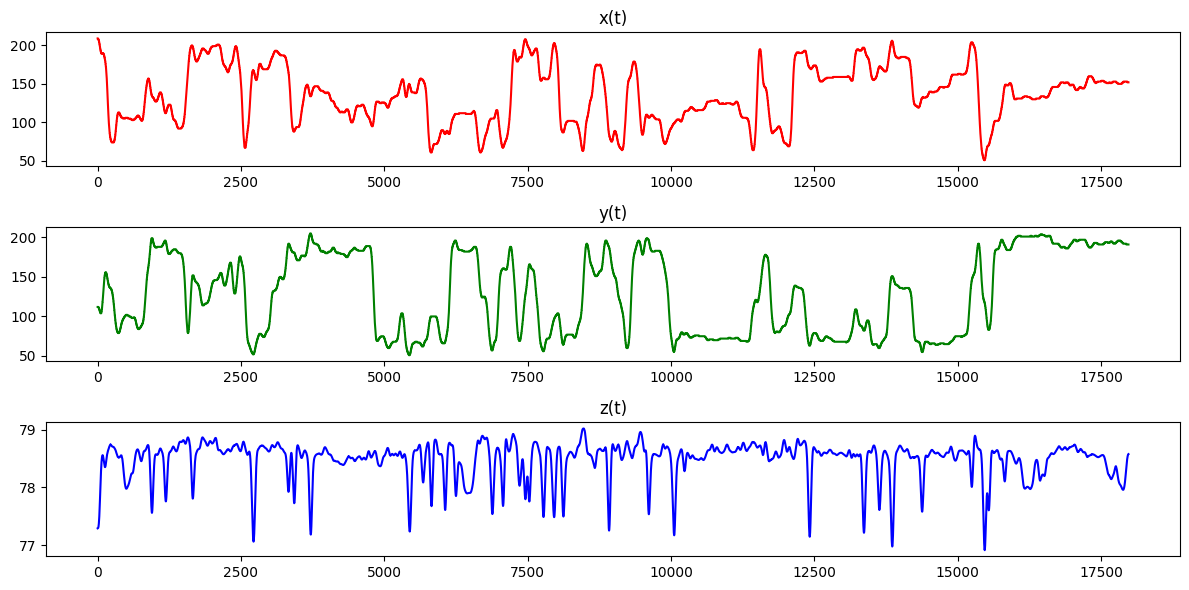

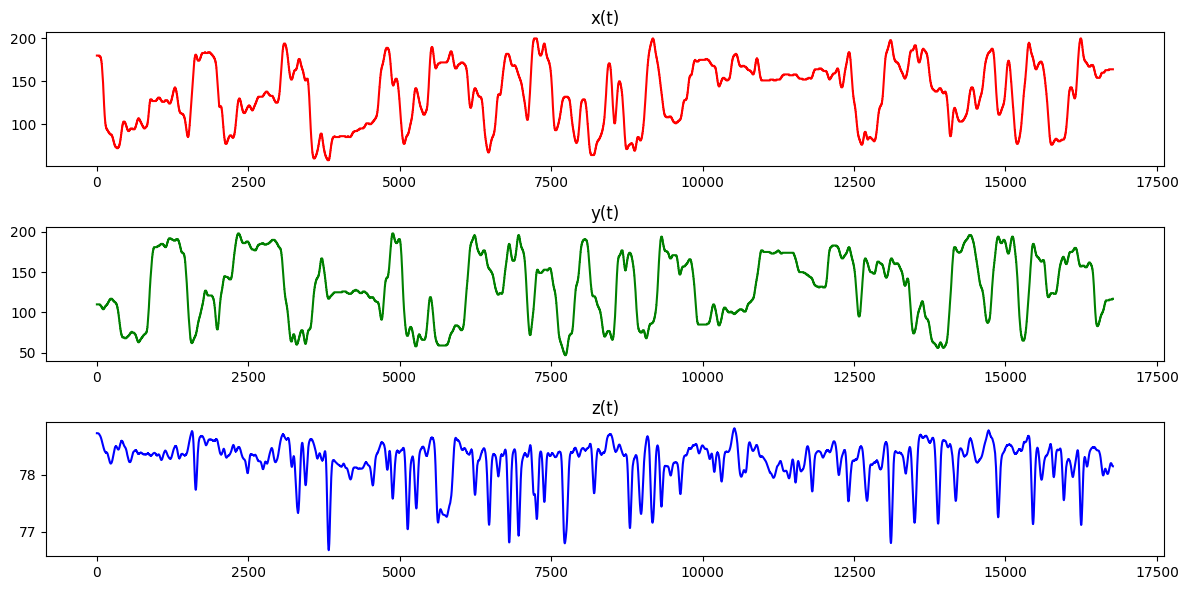

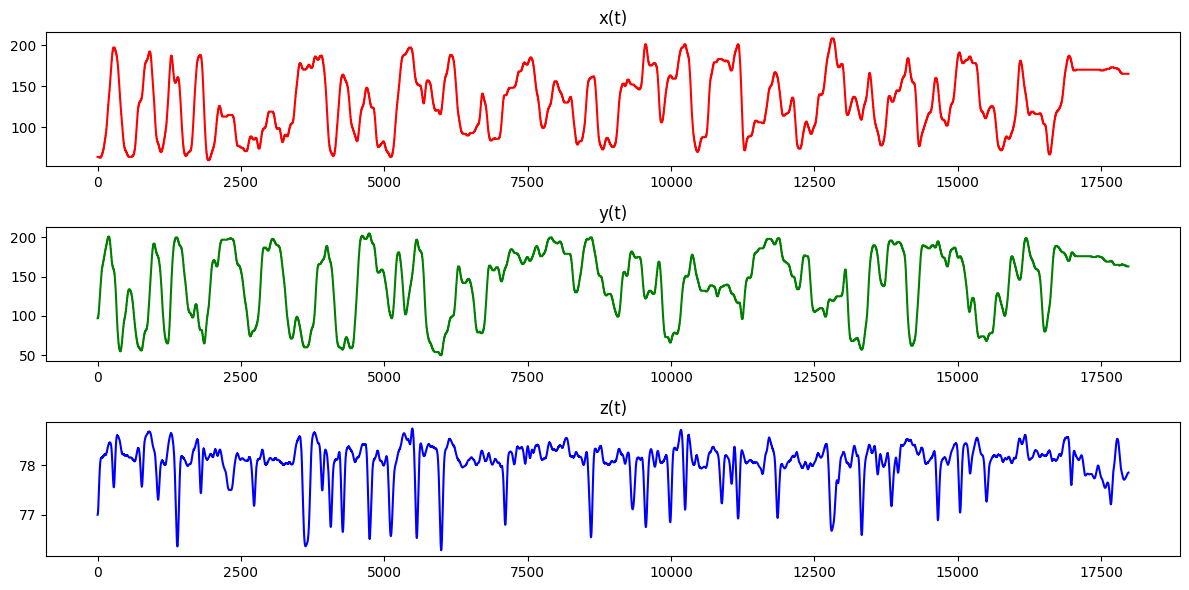

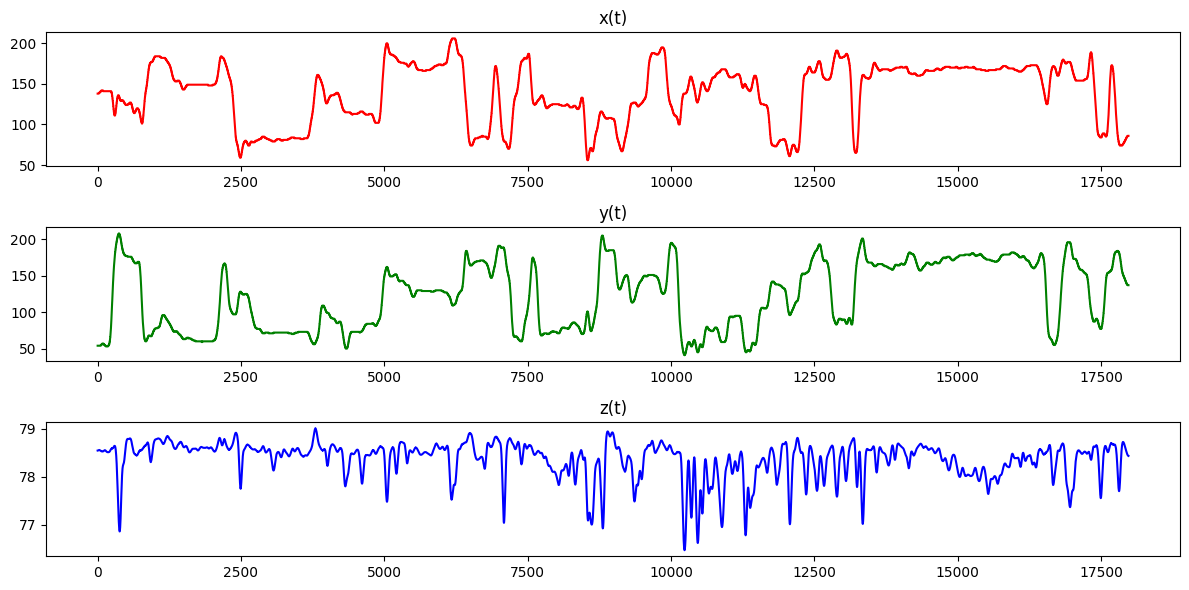

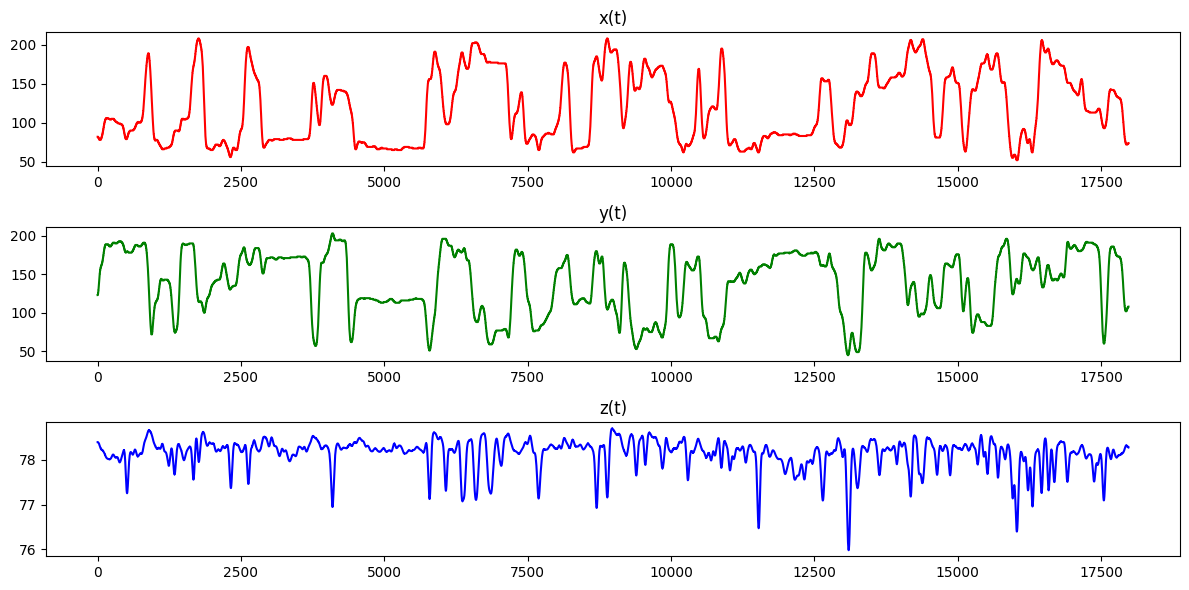

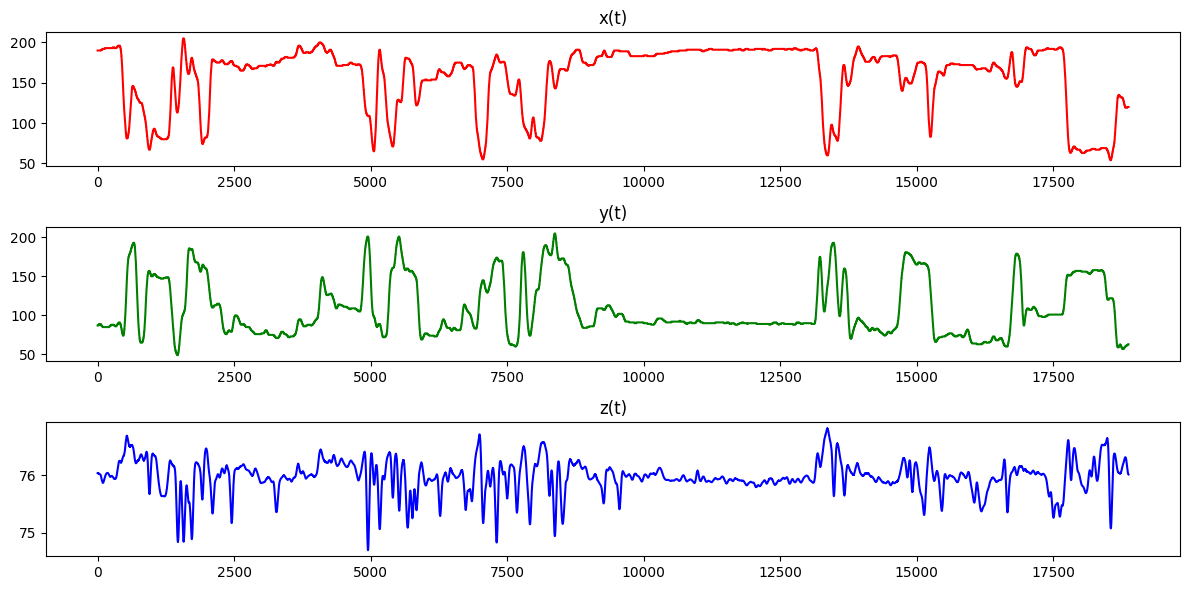

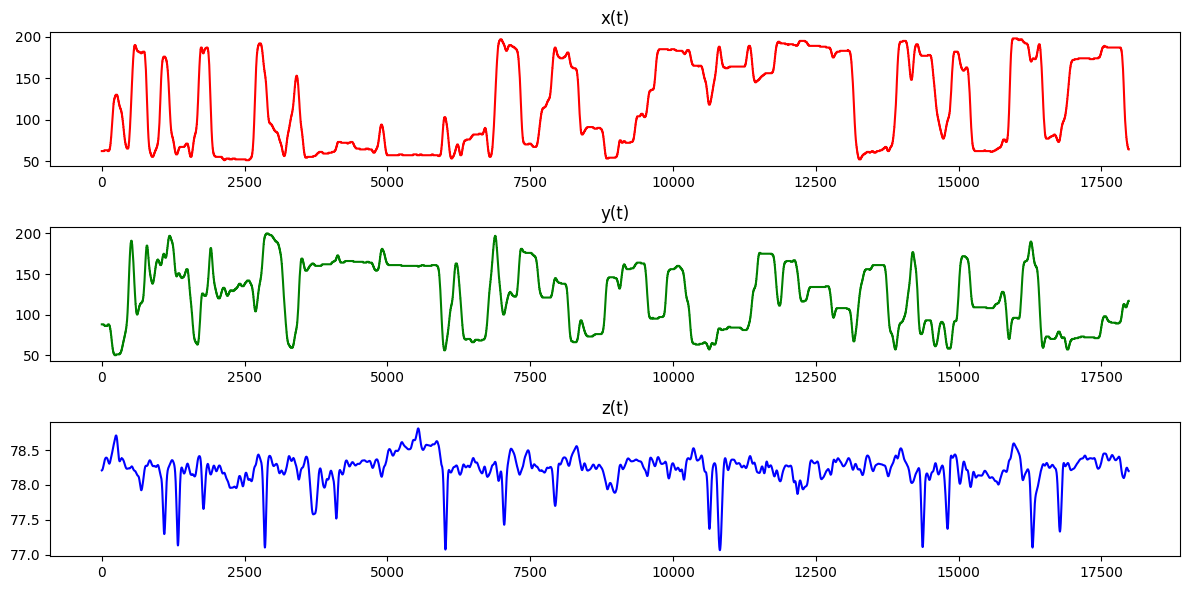

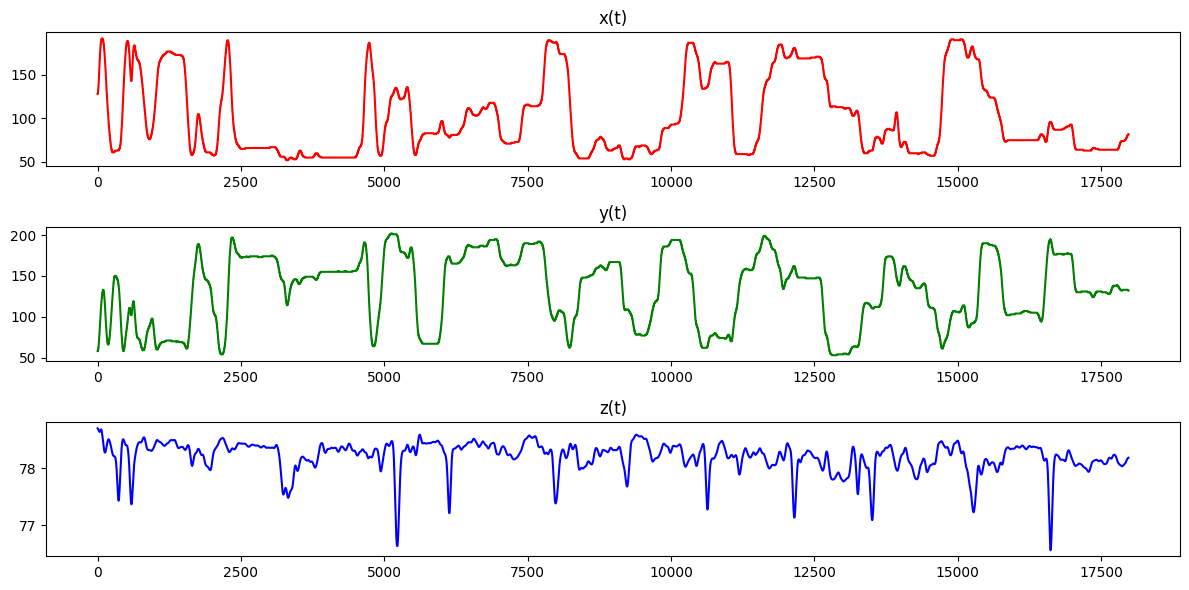

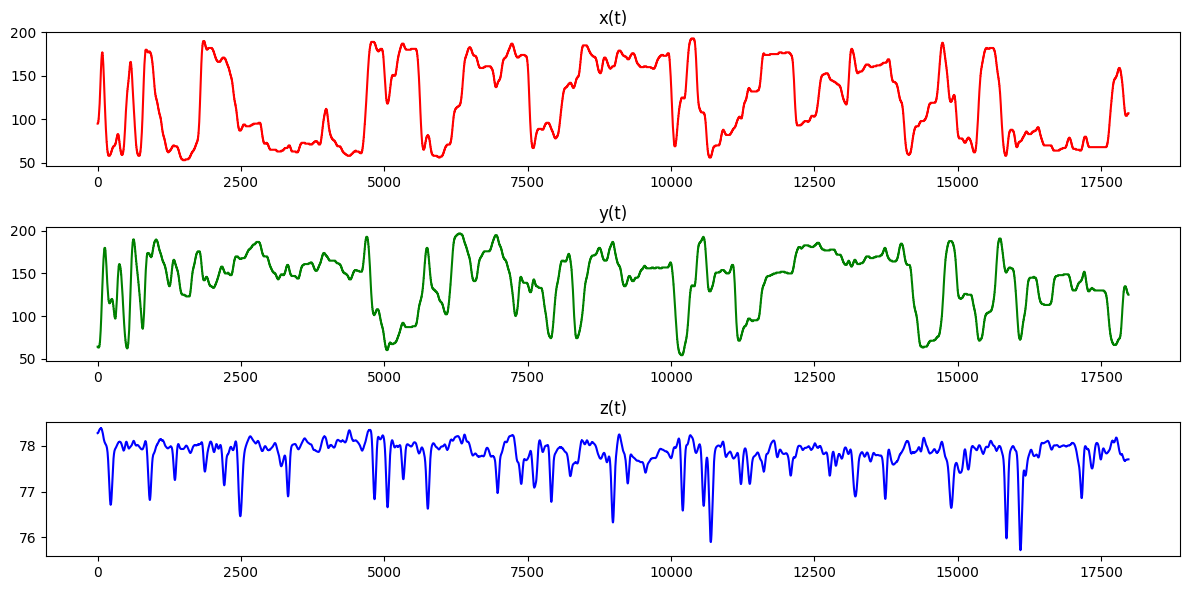

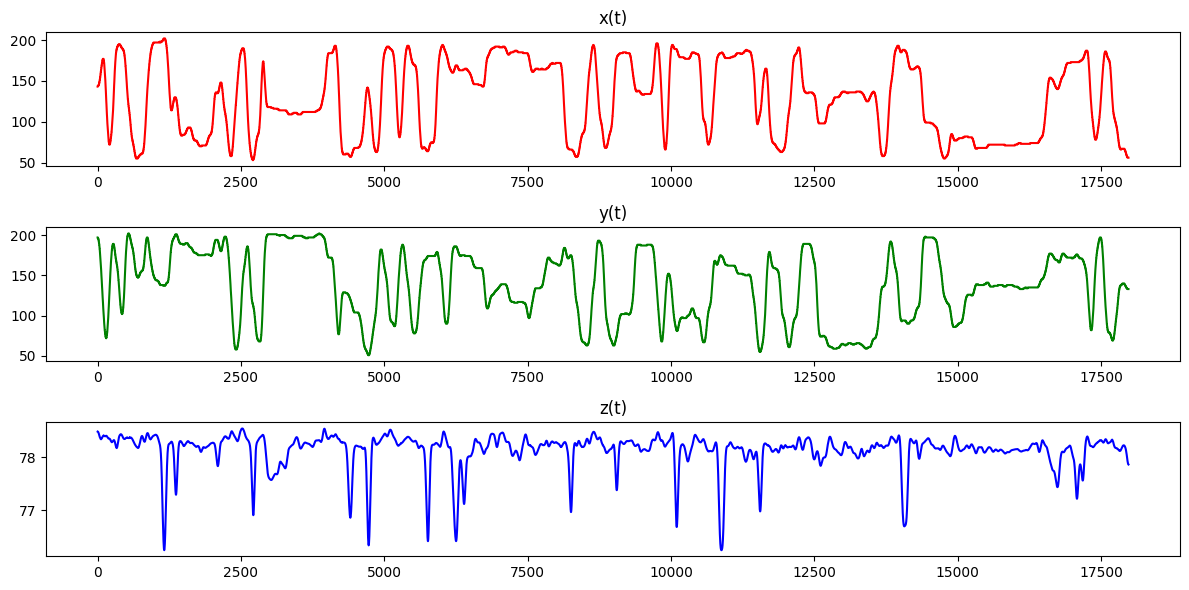

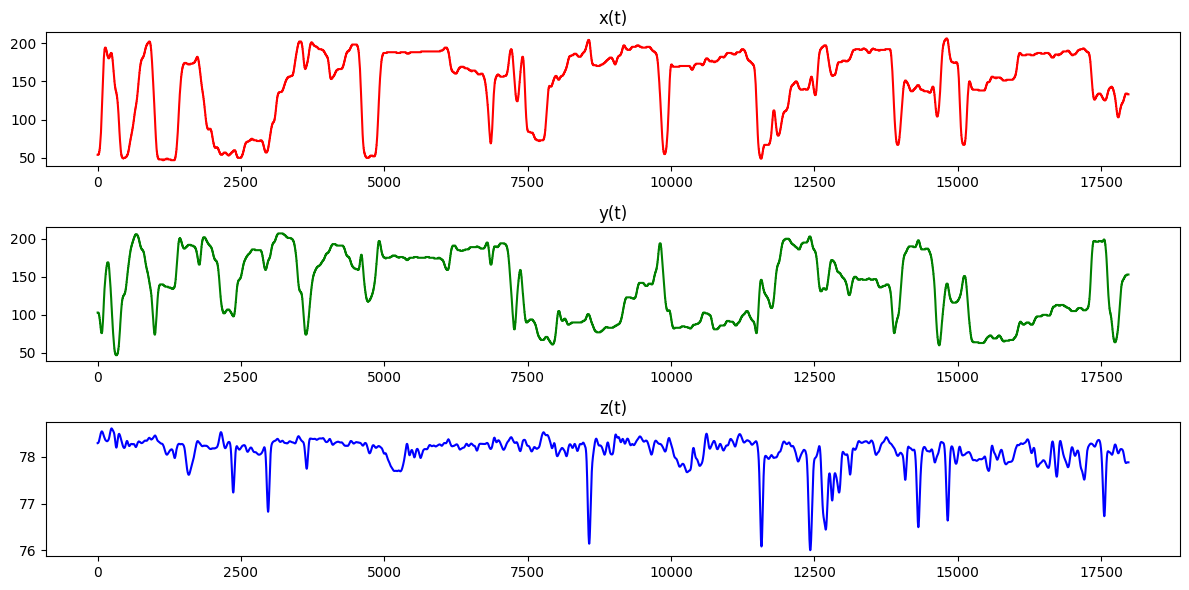

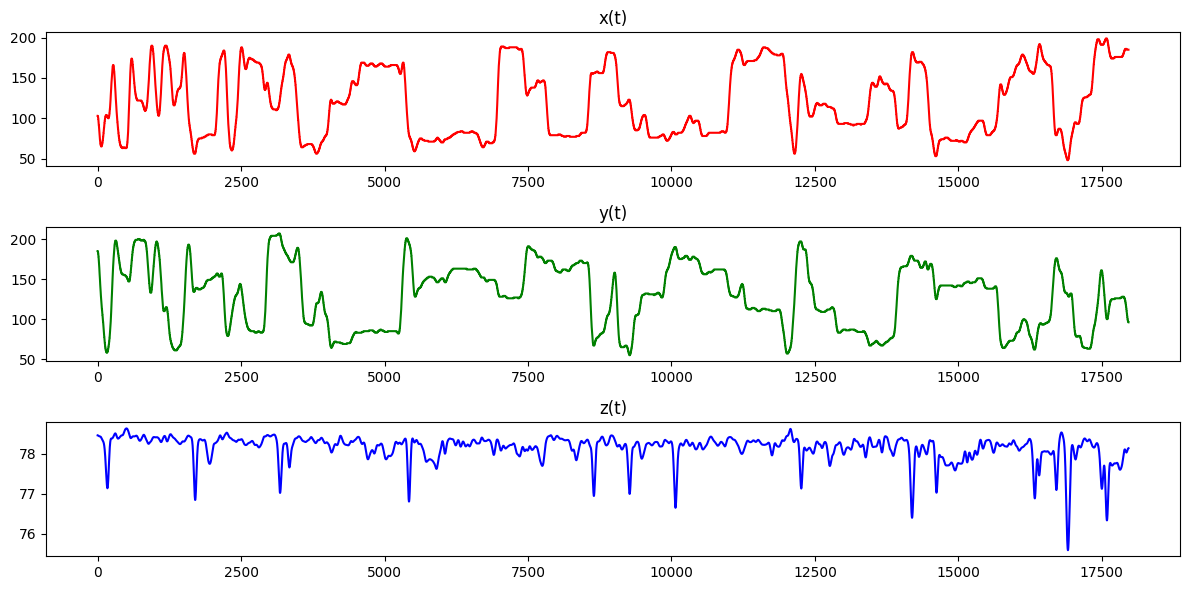

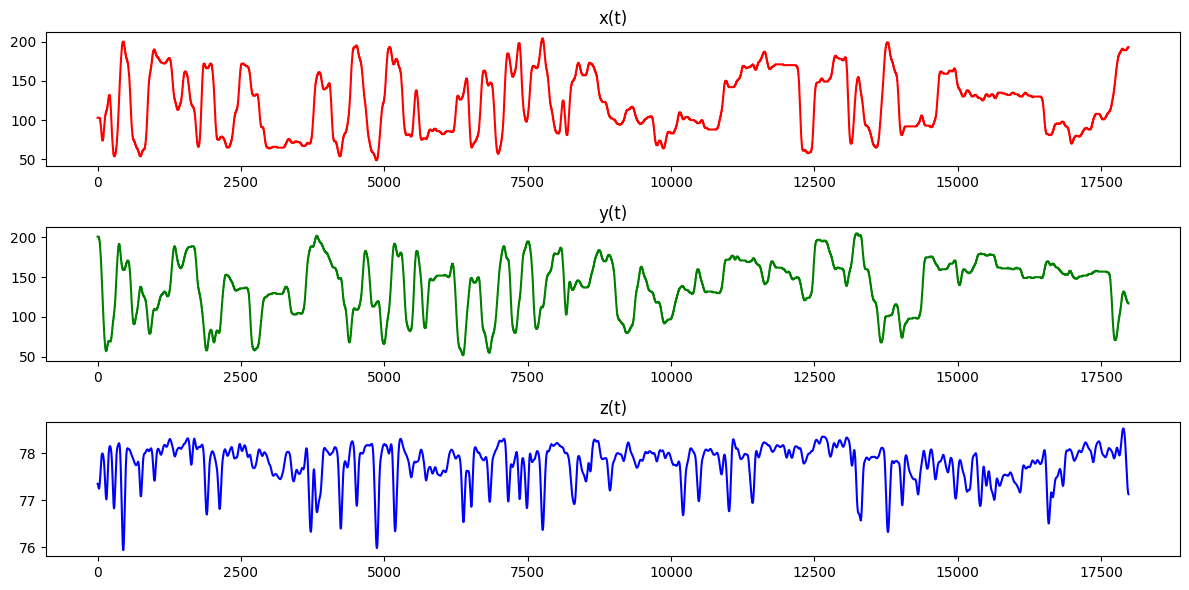

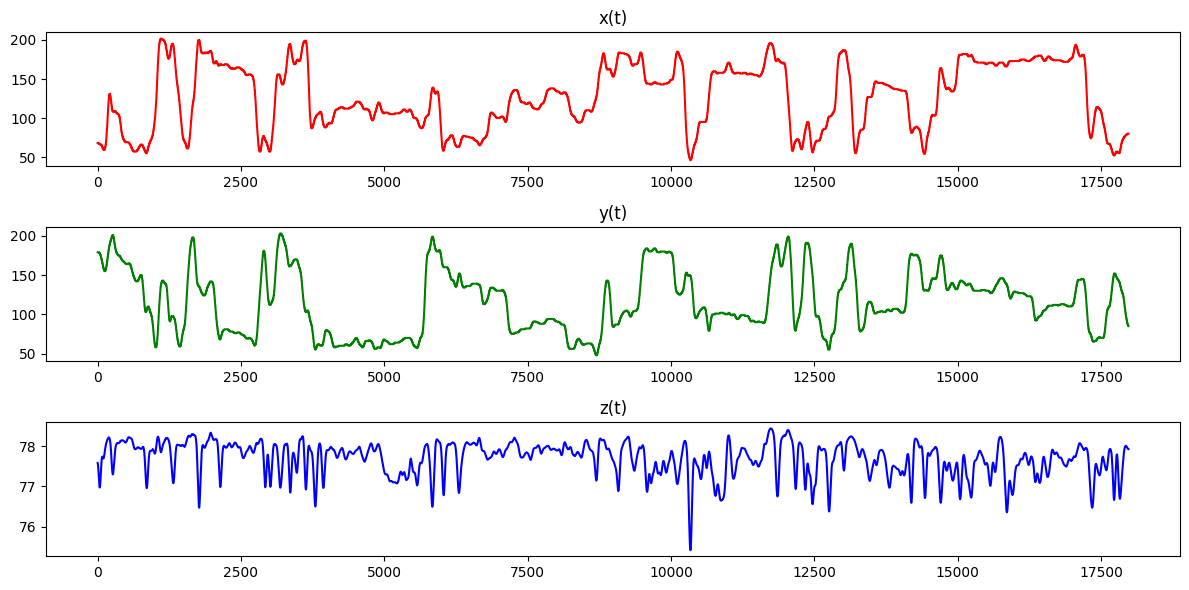

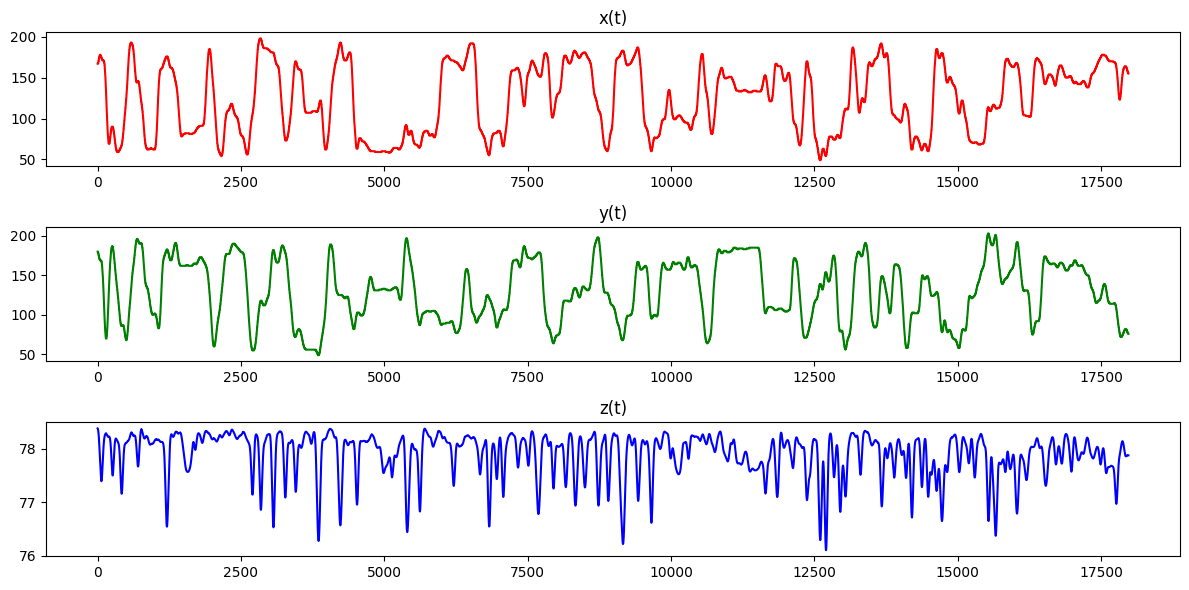

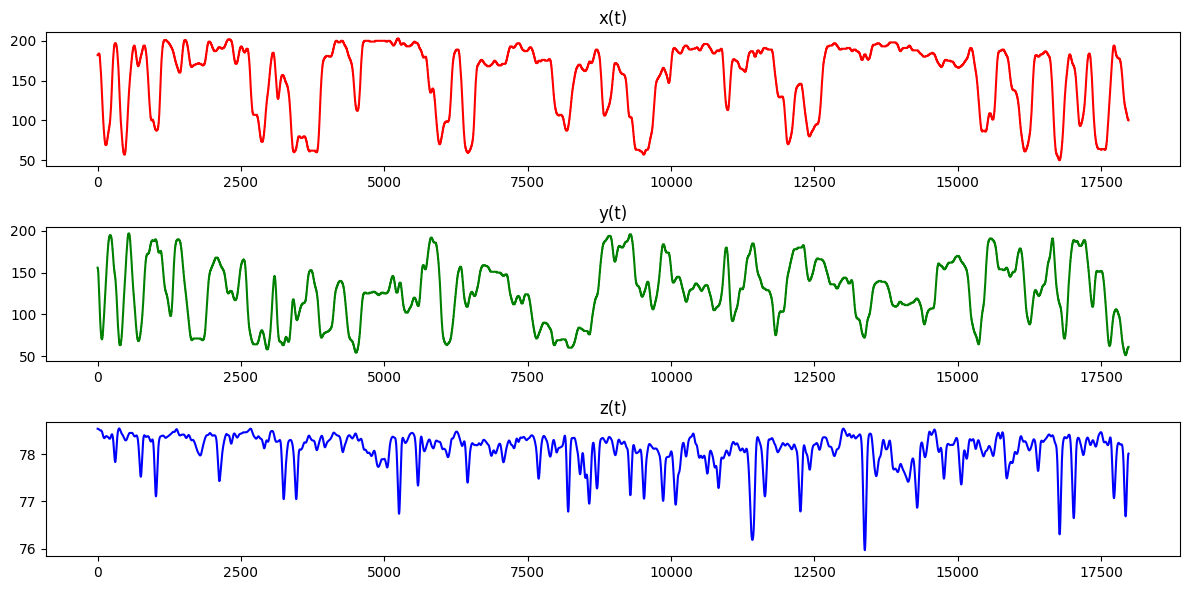

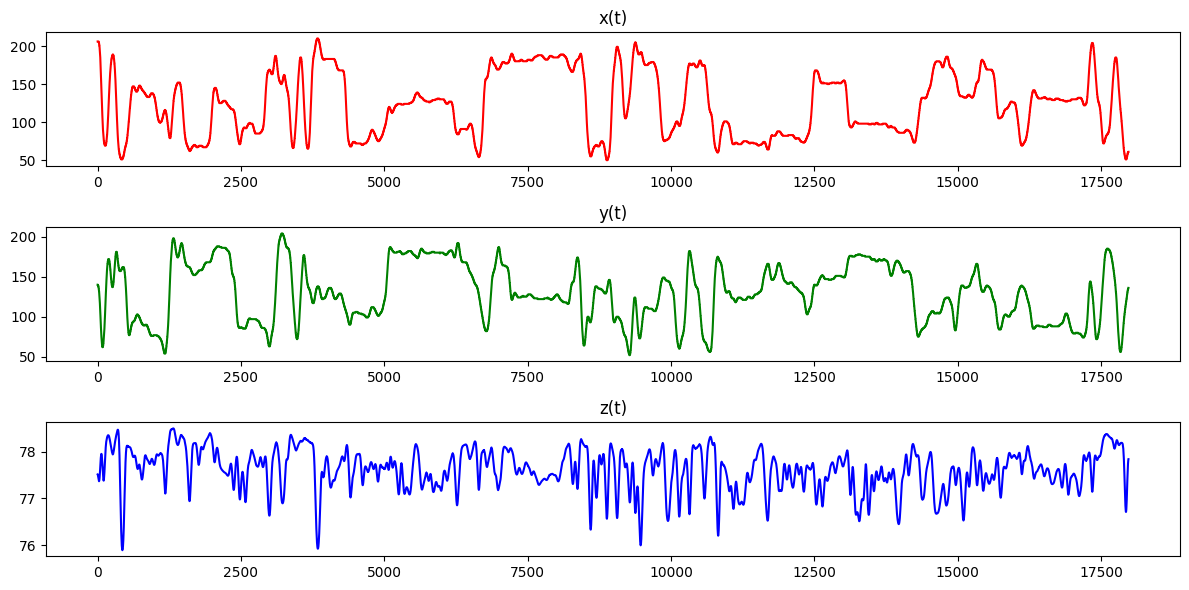

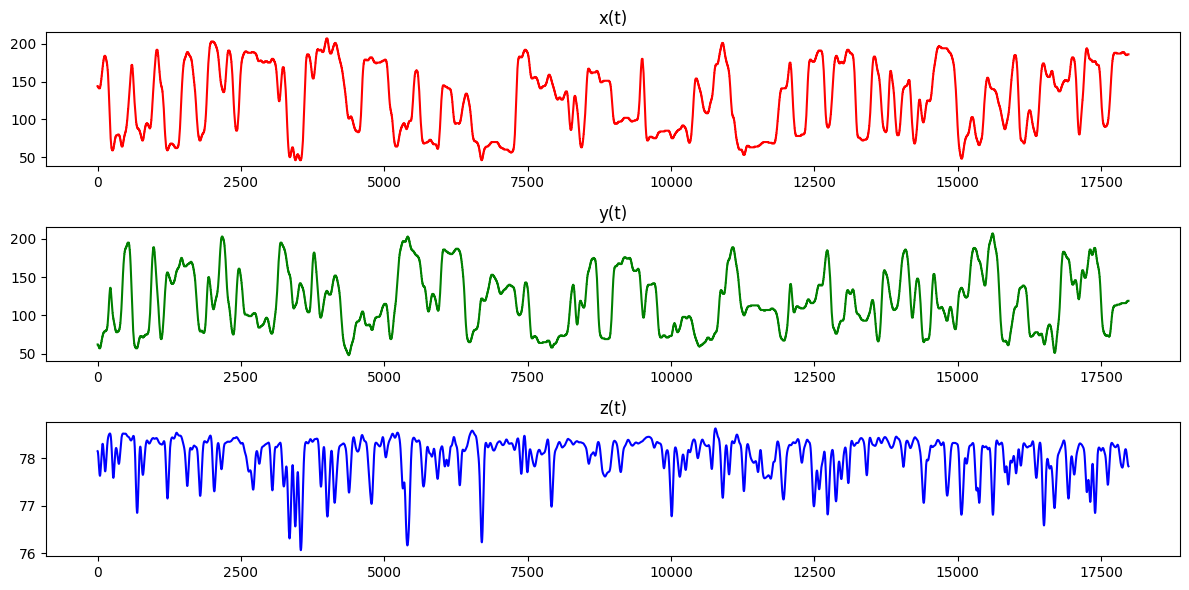

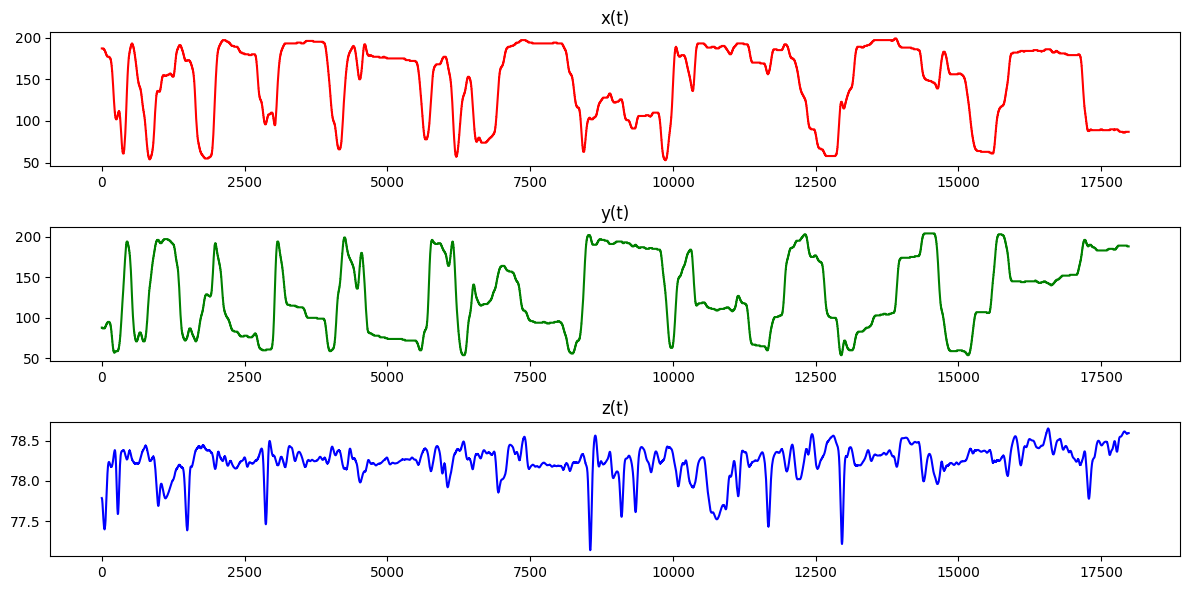

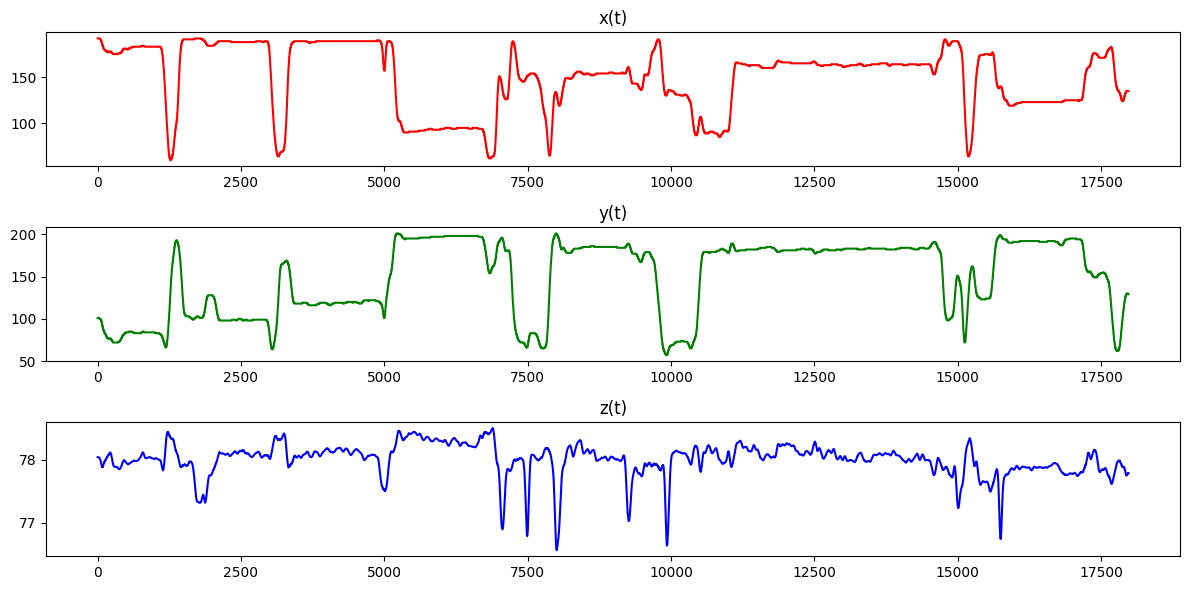

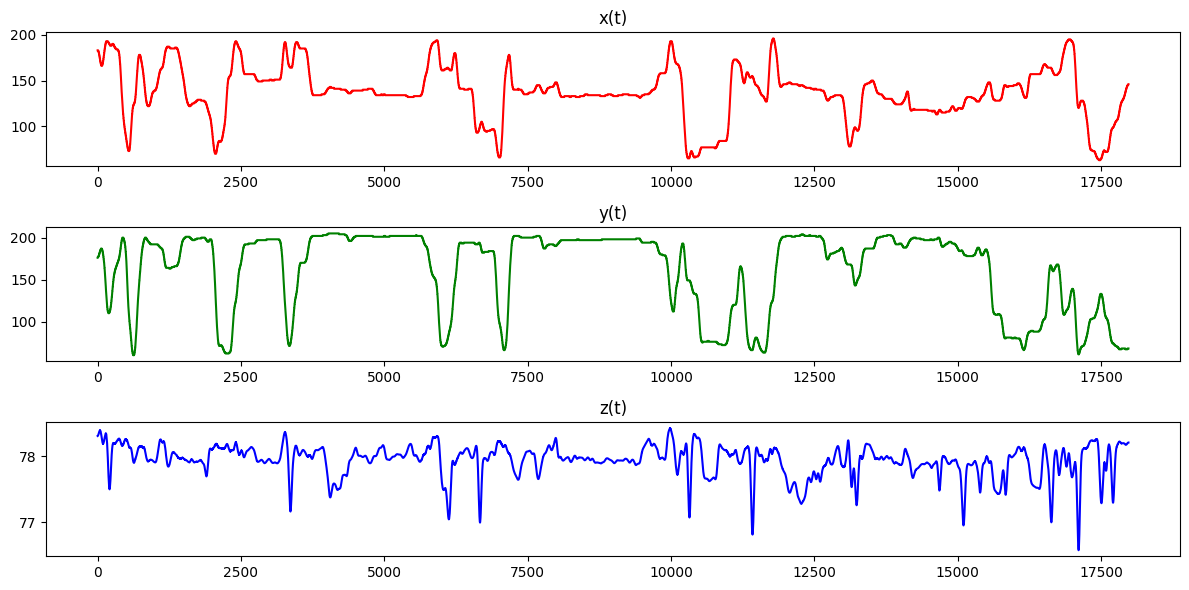

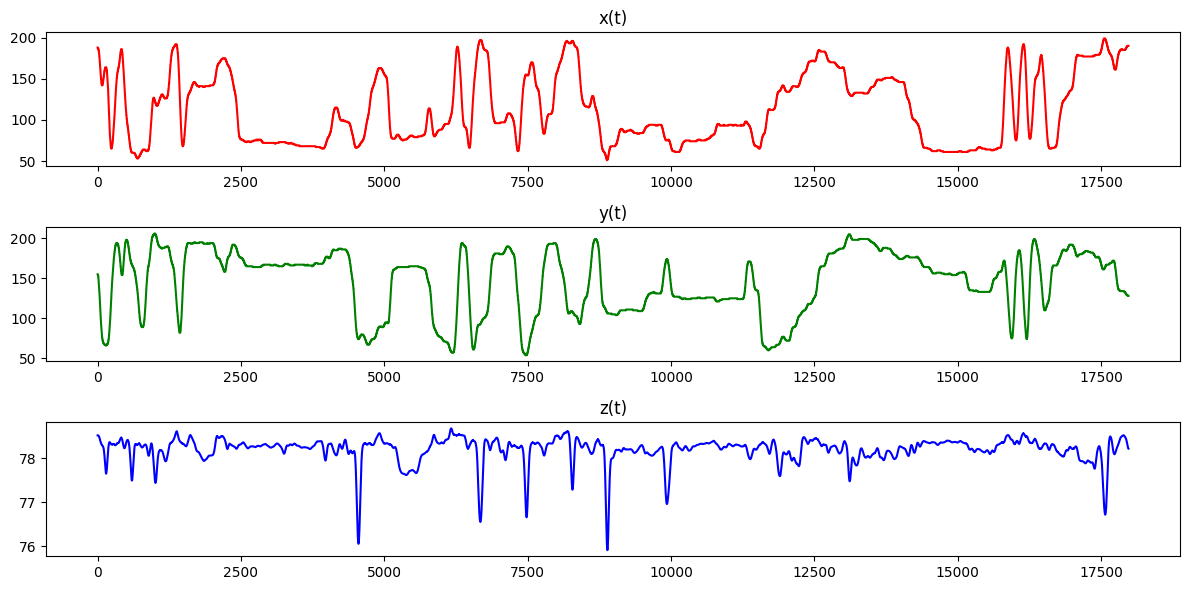

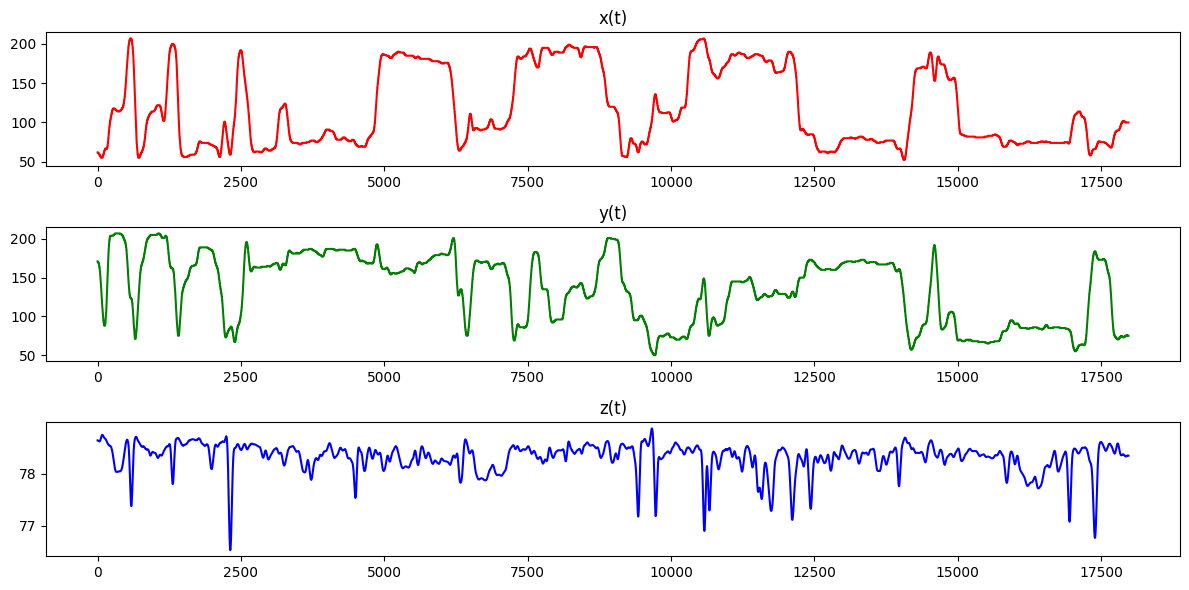

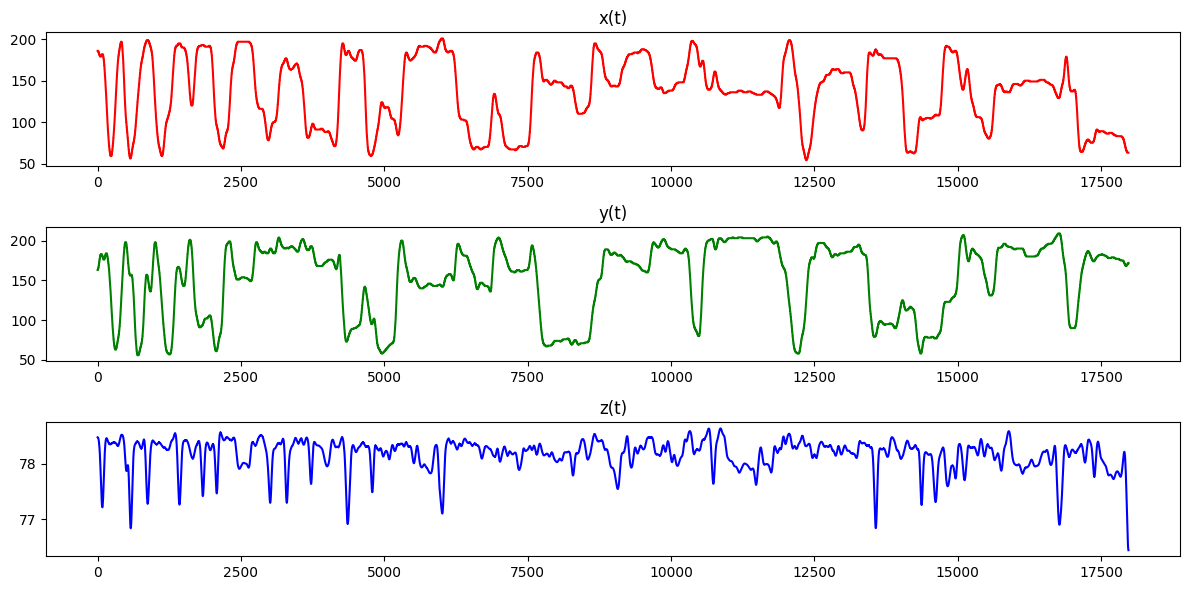

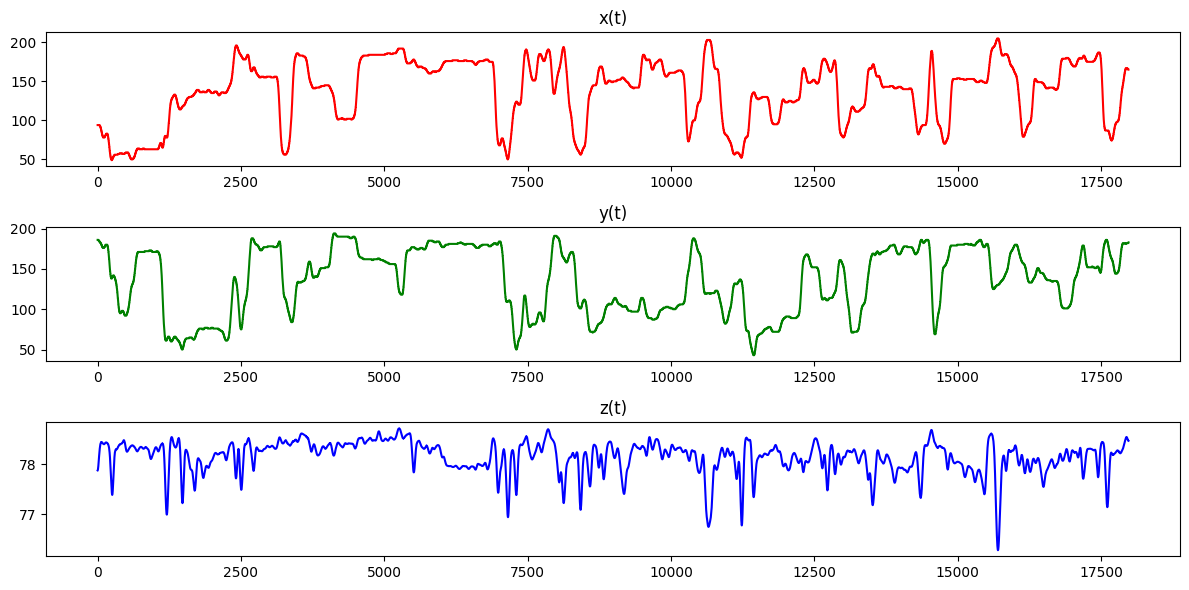

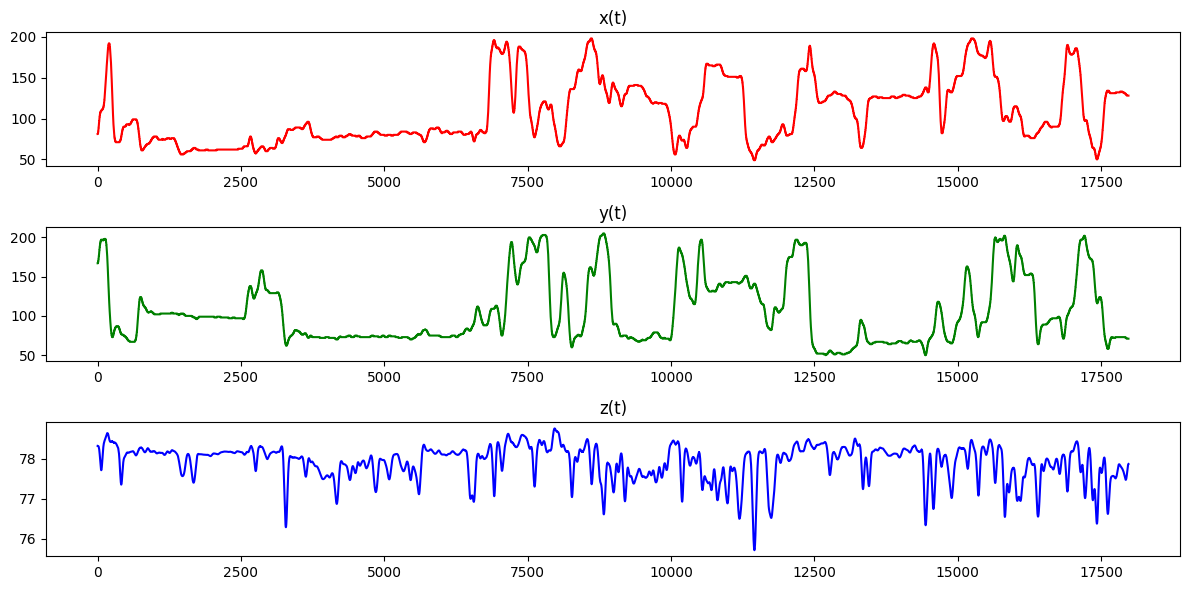

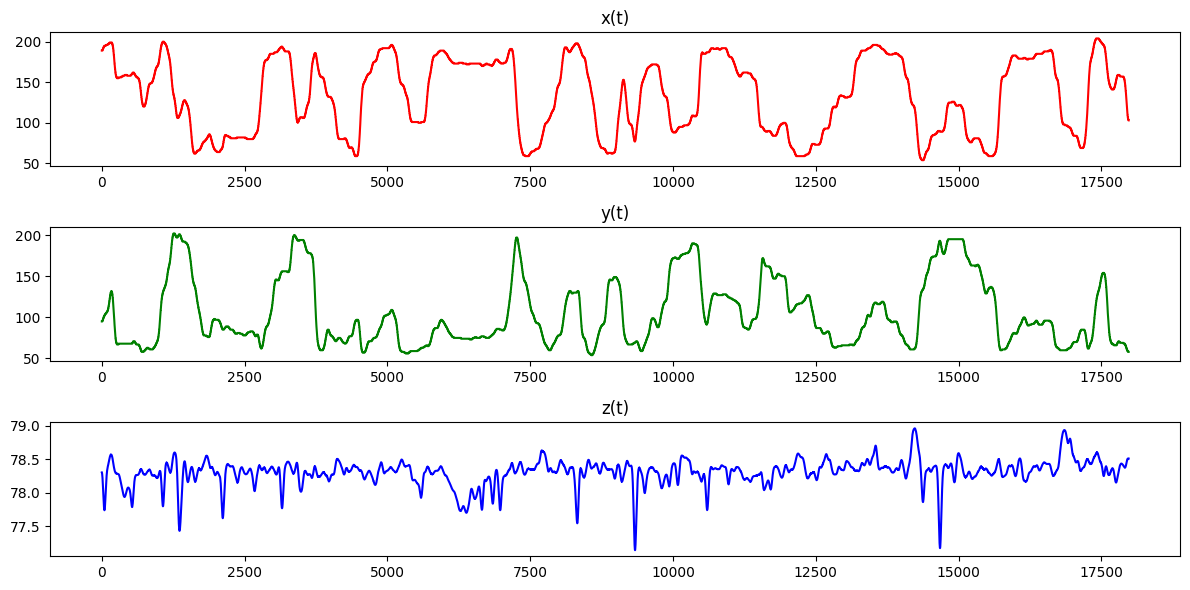

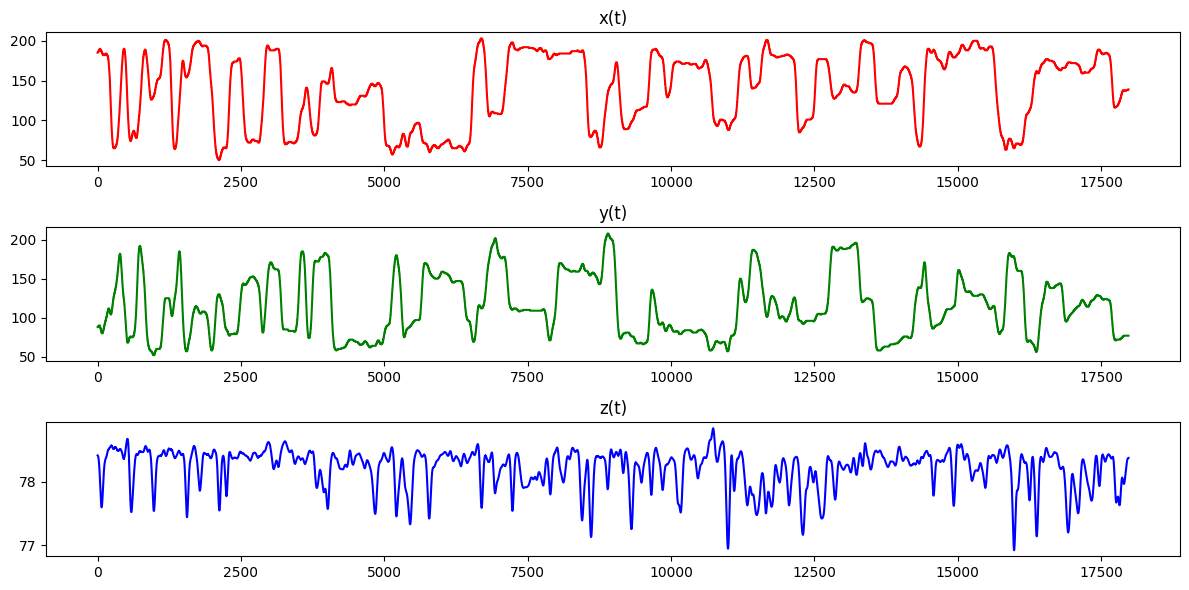

In [14]:
for i in range(len(dataset_list)):
    coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    show_coords(coord_dict)

In [48]:
total_mvt = []
for i in range(len(dataset_list)):
    coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    #show_coords(coord_dict)
    total_mvt.append(total_movement(coord_dict['coords']))

In [58]:
S1 = dataset_list[0:13]
S2 = dataset_list[13:26]
S3 = dataset_list[26:38]
S4 = dataset_list[38:48]
S5 = dataset_list[48:55]
S6 = dataset_list[55:]

['/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M28_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M29_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M33_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M37_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M38_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M39_S6',
 '/Users/vincentchouinard/Documents/Maitrise/Behavior/BH_S6/BH_M42_S6']

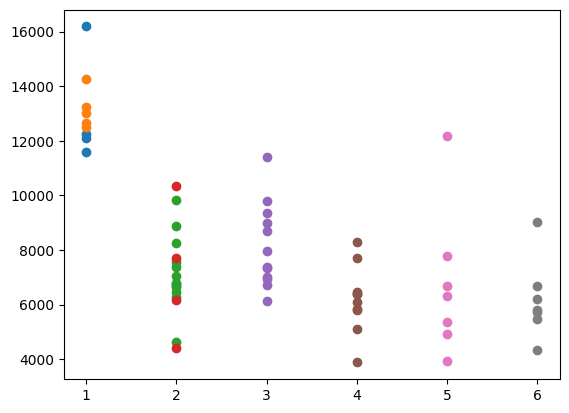

In [59]:
plt.scatter([1]*len(total_mvt[:4]),total_mvt[:4])
plt.scatter([1]*len(total_mvt[8:13]),total_mvt[8:13])
plt.scatter([2]*len(total_mvt[13:26]),total_mvt[13:26])
plt.scatter([2]*len(total_mvt[4:8]),total_mvt[4:8])
plt.scatter([3]*len(total_mvt[26:38]),total_mvt[26:38])
plt.scatter([4]*len(total_mvt[38:48]),total_mvt[38:48])
plt.scatter([5]*len(total_mvt[48:55]),total_mvt[48:55])
plt.scatter([6]*len(total_mvt[55:]),total_mvt[55:])

In [151]:
pixel_cm = 5.77

In [152]:
dist_s1 = []
dist_s2 = []
dist_s3 = []
dist_s4 = []
dist_s5 = []
dist_s6 = []

for i in tqdm(range(len(dataset_list))):
    data_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    distance = total_movement(data_dict['coords']) / pixel_cm
    distance = distance / (data_dict["coords"].shape[0]/17980)
    
    
    if "BH_S1" in dataset_list[i]:
        dist_s1.append(distance)
    elif "BH_S2" in dataset_list[i]:
        dist_s2.append(distance)
    elif "BH_S3" in dataset_list[i]:
        dist_s3.append(distance)
    elif "BH_S4" in dataset_list[i]:
        dist_s4.append(distance)
    elif "BH_S5" in dataset_list[i]:
        dist_s5.append(distance)
    elif "BH_S6" in dataset_list[i]:
        dist_s6.append(distance)
        


  0%|          | 0/62 [00:00<?, ?it/s]

In [153]:
dist_M28 = []
dist_M29 = []
dist_M31 = []
dist_M33 = []
dist_M34 = []
dist_M35 = []
dist_M37 = []
dist_M38 = []
dist_M39 = []
dist_M40 = []
dist_M41 = []
dist_M42 = []
dist_M43 = []
dist_M44 = []

for i in tqdm(range(len(dataset_list))):
    data_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    distance = total_movement(data_dict["coords"]) / pixel_cm
    distance = distance / (data_dict["coords"].shape[0]/17980)

    
    if "M28" in dataset_list[i]:
        dist_M28.append(distance)
    elif "M29" in dataset_list[i]:
        dist_M29.append(distance)
    elif "M31" in dataset_list[i]:
        dist_M31.append(distance)
    elif "M33" in dataset_list[i]:
        dist_M33.append(distance)
    elif "M34" in dataset_list[i]:
        dist_M34.append(distance)
    elif "M35" in dataset_list[i]:
        dist_M35.append(distance)
    elif "M37" in dataset_list[i]:
        dist_M37.append(distance)
    elif "M38" in dataset_list[i]:
        dist_M38.append(distance)
    elif "M39" in dataset_list[i]:
        dist_M39.append(distance)
    elif "M40" in dataset_list[i]:
        dist_M40.append(distance)
    elif "M41" in dataset_list[i]:
        dist_M41.append(distance)
    elif "M42" in dataset_list[i]:
        dist_M42.append(distance)
    elif "M43" in dataset_list[i]:
        dist_M43.append(distance)
    elif "M44" in dataset_list[i]:
        dist_M44.append(distance)

  0%|          | 0/62 [00:00<?, ?it/s]

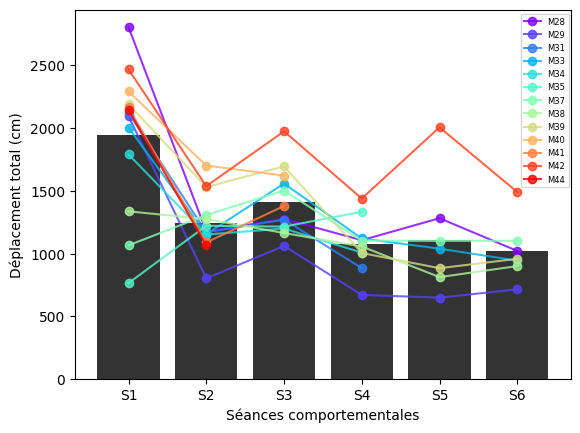

In [154]:
# Create subplots
fig, ax = plt.subplots()

# Define the number of colors
num_colors = 13

# Create a list of colors ranging from red to blue
colors = plt.cm.(np.linspace(0, 1, num_colors))

ax.bar(0,np.mean(dist_s1), color = 'black', alpha=0.8)
ax.bar(1,np.mean(dist_s2), color = 'black', alpha=0.8)
ax.bar(2,np.mean(dist_s3), color = 'black', alpha=0.8)
ax.bar(3,np.mean(dist_s4), color = 'black', alpha=0.8)
ax.bar(4,np.mean(dist_s5), color = 'black', alpha=0.8)
ax.bar(5,np.mean(dist_s6), color = 'black', alpha=0.8)

ax.plot([0,1,2,3,4,5], dist_M28, color = colors[0], marker='o', label= 'M28', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M29, color = colors[1], marker='o', label= 'M29', alpha=0.8)
ax.plot([0,1,2,3], dist_M31, color = colors[2], marker='o', label= 'M31', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M33, color = colors[3], marker='o', label= 'M33', alpha=0.8)
ax.plot([0,1,2,3], dist_M34, color = colors[4], marker='o', label= 'M34', alpha=0.8)
ax.plot([0,1,2,3], dist_M35, color = colors[5], marker='o', label= 'M35', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M37, color = colors[6], marker='o', label= 'M37', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M38, color = colors[7], marker='o', label= 'M38', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M39, color = colors[8], marker='o', label= 'M39', alpha=0.8)
ax.plot([0,1,2], dist_M40, color = colors[9], marker='o', label= 'M40', alpha=0.8)
ax.plot([0,1,2], dist_M41, color = colors[10], marker='o', label= 'M41', alpha=0.8)
ax.plot([0,1,2,3,4,5], dist_M42, color = colors[11], marker='o', label= 'M42', alpha=0.8)
ax.plot([0,1], dist_M44, color = colors[12], marker='o', label= 'M44', alpha=0.8)


ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['S1', 'S2', 'S3', 'S4', 'S5', 'S6'])
ax.set_xlabel("Séances comportementales")
ax.set_ylabel("Déplacement total (cm)")



# Adjust legend size and placement
legend = ax.legend(prop={'size': 6}, bbox_to_anchor=(0.89, 1), loc='upper left')


plt.show()

In [115]:
length = []
for i in range(len(dataset_list)):
    coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    length.append(coord_dict["coords"].shape[0])

In [158]:
def wall_crawling(coord_dict, r, center):
    
    coords = coord_dict['coords']
    
    x, y = coords[:, 0], coords[:, 1]
    cx, cy = center
    
    total_len = coords.shape[0]

    # Calculate the squared distance from the center for each point
    squared_distances = (x - cx)**2 + (y - cy)**2

    # Count the number of points outside the radius
    outside_count = np.sum(squared_distances > r**2)
    
    wall_crawl_ratio = outside_count / total_len * 100

    return wall_crawl_ratio

In [159]:
wall_crawling(coord_dict , r=55 , center=[130,130])

68.44279661016948

In [162]:
# Wall crawling percentage

wc = []
for i in range(len(dataset_list)):
    coord_dict = load_dict(dataset_list[i] + "/metadata.pkl")
    wc.append(wall_crawling(coord_dict, r=55, center=[130,130]))

wc_dist_M28 = []
wc_dist_M29 = []
wc_dist_M31 = []
wc_dist_M33 = []
wc_dist_M34 = []
wc_dist_M35 = []
wc_dist_M37 = []
wc_dist_M38 = []
wc_dist_M39 = []
wc_dist_M40 = []
wc_dist_M41 = []
wc_dist_M42 = []
wc_dist_M43 = []
wc_dist_M44 = []

for i in tqdm(range(len(dataset_list))):
    
    if "M28" in dataset_list[i]:
        wc_dist_M28.append(wc[i])
    elif "M29" in dataset_list[i]:
        wc_dist_M29.append(wc[i])
    elif "M31" in dataset_list[i]:
        wc_dist_M31.append(wc[i])
    elif "M33" in dataset_list[i]:
        wc_dist_M33.append(wc[i])
    elif "M34" in dataset_list[i]:
        wc_dist_M34.append(wc[i])
    elif "M35" in dataset_list[i]:
        wc_dist_M35.append(wc[i])
    elif "M37" in dataset_list[i]:
        wc_dist_M37.append(wc[i])
    elif "M38" in dataset_list[i]:
        wc_dist_M38.append(wc[i])
    elif "M39" in dataset_list[i]:
        wc_dist_M39.append(wc[i])
    elif "M40" in dataset_list[i]:
        wc_dist_M40.append(wc[i])
    elif "M41" in dataset_list[i]:
        wc_dist_M41.append(wc[i])
    elif "M42" in dataset_list[i]:
        wc_dist_M42.append(wc[i])
    elif "M43" in dataset_list[i]:
        wc_dist_M43.append(wc[i])
    elif "M44" in dataset_list[i]:
        wc_dist_M44.append(wc[i])

  0%|          | 0/62 [00:00<?, ?it/s]

In [169]:
wc_dist_s1 = []
wc_dist_s2 = []
wc_dist_s3 = []
wc_dist_s4 = []
wc_dist_s5 = []
wc_dist_s6 = []

for i in tqdm(range(len(dataset_list))):
    
    
    if "BH_S1" in dataset_list[i]:
        wc_dist_s1.append(wc[i])
    elif "BH_S2" in dataset_list[i]:
        wc_dist_s2.append(wc[i])
    elif "BH_S3" in dataset_list[i]:
        wc_dist_s3.append(wc[i])
    elif "BH_S4" in dataset_list[i]:
        wc_dist_s4.append(wc[i])
    elif "BH_S5" in dataset_list[i]:
        wc_dist_s5.append(wc[i])
    elif "BH_S6" in dataset_list[i]:
        wc_dist_s6.append(wc[i])

  0%|          | 0/62 [00:00<?, ?it/s]

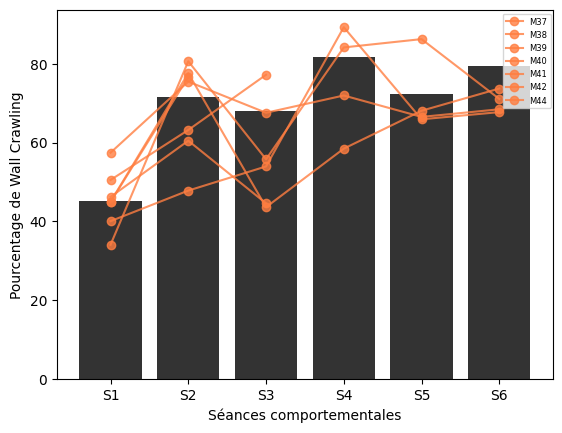

In [184]:
# Create subplots
fig, ax = plt.subplots()

# Define the number of colors
num_colors = 13

# Create a list of colors ranging from red to blue
colors = plt.cm.rainbow(np.linspace(0, 1, num_colors))

ax.bar(0,np.mean(wc_dist_s1), color = 'black', alpha=0.8)
ax.bar(1,np.mean(wc_dist_s2), color = 'black', alpha=0.8)
ax.bar(2,np.mean(wc_dist_s3), color = 'black', alpha=0.8)
ax.bar(3,np.mean(wc_dist_s4), color = 'black', alpha=0.8)
ax.bar(4,np.mean(wc_dist_s5), color = 'black', alpha=0.8)
ax.bar(5,np.mean(wc_dist_s6), color = 'black', alpha=0.8)

ax.plot([0,1,2,3,4,5], wc_dist_M28, color = colors[1], marker='o', label= 'M28', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M29, color = colors[1], marker='o', label= 'M29', alpha=0.8)
ax.plot([0,1,2,3], wc_dist_M31, color = colors[1], marker='o', label= 'M31', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M33, color = colors[1], marker='o', label= 'M33', alpha=0.8)
ax.plot([0,1,2,3], wc_dist_M34, color = colors[1], marker='o', label= 'M34', alpha=0.8)
ax.plot([0,1,2,3], wc_dist_M35, color = colors[1], marker='o', label= 'M35', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M37, color = colors[10], marker='o', label= 'M37', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M38, color = colors[10], marker='o', label= 'M38', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M39, color = colors[10], marker='o', label= 'M39', alpha=0.8)
ax.plot([0,1,2], wc_dist_M40, color = colors[10], marker='o', label= 'M40', alpha=0.8)
ax.plot([0,1,2], wc_dist_M41, color = colors[10], marker='o', label= 'M41', alpha=0.8)
ax.plot([0,1,2,3,4,5], wc_dist_M42, color = colors[10], marker='o', label= 'M42', alpha=0.8)
ax.plot([0,1], wc_dist_M44, color = colors[10], marker='o', label= 'M44', alpha=0.8)


ax.set_xticks([0, 1, 2, 3, 4, 5])
ax.set_xticklabels(['S1', 'S2', 'S3', 'S4', 'S5', 'S6'])
ax.set_xlabel("Séances comportementales")
ax.set_ylabel("Pourcentage de Wall Crawling")



# Adjust legend size and placement
legend = ax.legend(prop={'size': 6}, bbox_to_anchor=(0.89, 1), loc='upper left')


plt.show()

In [177]:
110**2 / 170**2

0.4186851211072664